In [1]:
import rishi_utils as ru
from rdkit import Chem
import fall20_mse_8803 as retro
import importlib
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
importlib.reload(retro)
importlib.reload(ru)
import numpy as np
import pickle
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 600
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


# Make ring-closing rxn

In [2]:
importlib.reload(ru)

<module 'rishi_utils' from '/home/rgur/py_scripts/rishi_utils.py'>

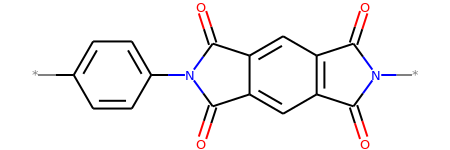

In [3]:
mol = Chem.MolFromSmiles('*c4ccc(n3c(=O)c2cc1c(=O)n(*)c(=O)c1cc2c3=O)cc4')
mol

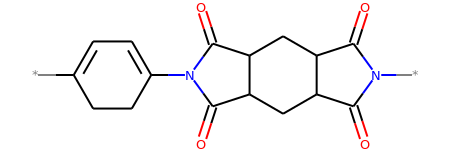

In [4]:
mol2 = Chem.MolFromSmiles('*c4ccc(N3C(=O)C2CC1C(=O)N(*)C(=O)C1CC2C3=O)CC4')
mol2

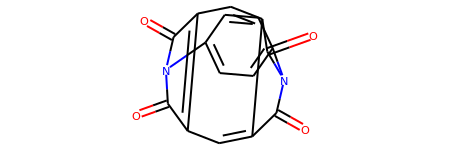

In [5]:
lp = ru.LinearPol(mol)
pm = lp.PeriodicMol()
pm.GetSSSR()
pm.mol

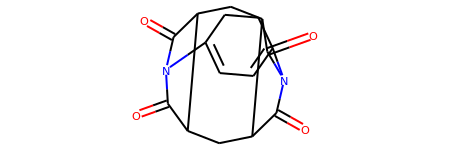

In [6]:
lp2 = ru.LinearPol(mol2)
pm2 = lp2.PeriodicMol()
pm2.GetSSSR()
pm2.mol

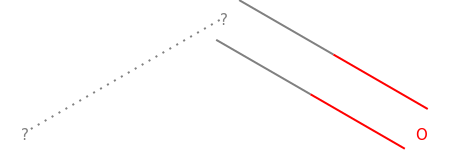

In [7]:
start_match = Chem.MolFromSmarts('[cR,CR](=O)[nR,NR]') #the ring we want to break
start_match

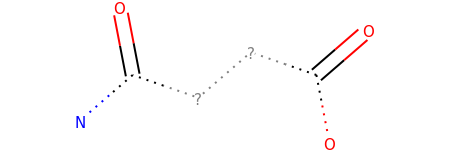

In [8]:
end_match = Chem.MolFromSmarts('[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]') #the group we want to end up with
end_match

In [9]:
pm.HasSubstructMatch(start_match),pm2.HasSubstructMatch(start_match)  #should be True, True

(True, True)

In [10]:
pm.mol.HasSubstructMatch(end_match),pm2.mol.HasSubstructMatch(end_match)  #should be False, False

(False, False)

In [11]:
import itertools

#works for non-aromatic systems
new_mol = None
new_mol2 = None
med_mol = None
lps = []
lp_no_connect_inds = np.array([x for x in range(lp.mol.GetNumAtoms()) if x not in lp.star_inds])
def lp_to_pm_ind(lp_ind):
    return int(np.argwhere(lp_no_connect_inds==lp_ind))

ri = lp.mol.GetRingInfo()
ar = ri.AtomRings()
ar_atom_idx = [a.GetIdx() for a in lp.mol.GetAromaticAtoms()]
atom_aromaticity = {a:0 for a in ar_atom_idx}

for ring in ar:
    if ring[0] in ar_atom_idx:
        for a in ring:
            atom_aromaticity[a] += 1

if pm.mol.HasSubstructMatch(start_match) and not pm.mol.HasSubstructMatch(end_match): 
    matches = pm.mol.GetSubstructMatches(start_match)
    for L in range(1, len(matches)+1):
    #for L in range(2,3):
        for match_combo in itertools.combinations(matches,L):
            em = Chem.EditableMol(pm.mol)
            print('Match combo:', match_combo)
            for i_c,i_o,i_n in match_combo: #indices of atoms in pm
                
                print('Matches: %s %s %s' %(i_c,i_o,i_n) )
                fix_aromaticity = False
                if pm.mol.GetBondBetweenAtoms(i_c,i_n).GetBondType() == Chem.BondType.AROMATIC:
                    fix_aromaticity = True
                    ring_atoms = None
                    ring_size = 100
                    for i in range(len(ar)):
                        ring = ar[i]
                        if lp_no_connect_inds[i_c] in ring and lp_no_connect_inds[i_n] in ring and len(ring) < ring_size: #assume correct ring is the smallest one
                            ring_atoms = set(ring)
                            ring_size = len(ring)

                o=em.AddAtom(Chem.AtomFromSmiles('O'))
                em.AddBond(i_c,o,Chem.BondType.SINGLE)
                print('bond between %s and %s' %(i_c,o))
                em.RemoveBond(i_c,i_n)
                print('Bond removed between %s and %s' %(i_c,i_n))

                med_mol = em.GetMol()
                if fix_aromaticity:
                    i_n_aromaticity = atom_aromaticity[ lp_to_pm_ind(i_n) ]
                    for i in ring_atoms:
                        if atom_aromaticity[ i ] == i_n_aromaticity: #if an atom was part of same number of aromatic rings as the N atom, it shouldn't be aromatic
                            print('Ring atom lp:',i)
                            pm_i = lp_to_pm_ind(i)
                            print('Ring atom pm:',pm_i)
                            med_mol.GetAtomWithIdx( pm_i ).SetIsAromatic(False)
                            #remove all aromatic bonds
                            neighs = [x.GetIdx() for x in med_mol.GetAtoms()[ pm_i ].GetNeighbors()]
                            aromatic_neighs = [x for x in neighs if med_mol.GetBondBetweenAtoms(pm_i,x).GetBondType()==Chem.BondType.AROMATIC]
                            print('Aromatic neighs of %s: %s' %(pm_i,aromatic_neighs))
                            em = Chem.EditableMol(med_mol)
                            for x in aromatic_neighs:
                                em.RemoveBond( x, pm_i )
                                em.AddBond(x,pm_i, Chem.BondType.SINGLE)
                            med_mol = em.GetMol()     
            
            em = Chem.EditableMol(med_mol)
            star1 = em.AddAtom(Chem.AtomFromSmiles('*'))
            star2 = em.AddAtom(Chem.AtomFromSmiles('*'))
            em.RemoveBond(pm.connector_inds[0],pm.connector_inds[1])
            em.AddBond(pm.connector_inds[0],star1,Chem.BondType.SINGLE)
            em.AddBond(pm.connector_inds[1],star2,Chem.BondType.SINGLE)

            new_mol=em.GetMol()
            print('#########')
            try:
                Chem.SanitizeMol(new_mol)
                lps.append( ru.LinearPol( ru.mol_without_atom_index(new_mol) ) )
            except:
                pass
else:
    print('None')

Match combo: ((5, 6, 4),)
Matches: 5 6 4
bond between 5 and 22
Bond removed between 5 and 4
Ring atom lp: 5
Ring atom pm: 4
Aromatic neighs of 4: [18]
Ring atom lp: 6
Ring atom pm: 5
Aromatic neighs of 5: [7]
Ring atom lp: 20
Ring atom pm: 18
Aromatic neighs of 18: [17]
#########
Match combo: ((10, 11, 12),)
Matches: 10 11 12
bond between 10 and 22
Bond removed between 10 and 12
Ring atom lp: 11
Ring atom pm: 10
Aromatic neighs of 10: [9]
Ring atom lp: 13
Ring atom pm: 12
Aromatic neighs of 12: [13]
Ring atom lp: 15
Ring atom pm: 13
Aromatic neighs of 13: [15]
#########
Match combo: ((13, 14, 12),)
Matches: 13 14 12
bond between 13 and 22
Bond removed between 13 and 12
Ring atom lp: 11
Ring atom pm: 10
Aromatic neighs of 10: [9, 12]
Ring atom lp: 13
Ring atom pm: 12
Aromatic neighs of 12: []
Ring atom lp: 15
Ring atom pm: 13
Aromatic neighs of 13: [15]
#########
Match combo: ((18, 19, 4),)
Matches: 18 19 4
bond between 18 and 22
Bond removed between 18 and 4
Ring atom lp: 5
Ring atom p

In [12]:
lps

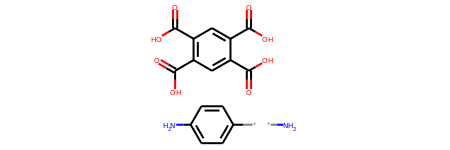

In [13]:
ru.mol_without_atom_index(new_mol)

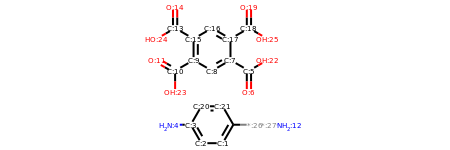

In [14]:
ru.mol_with_atom_index(new_mol)

In [15]:
len(lps

SyntaxError: unexpected EOF while parsing (<ipython-input-15-58e52bc9e295>, line 1)

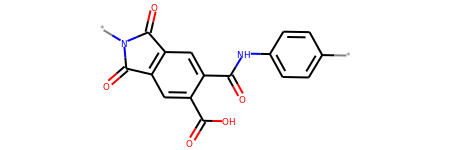

In [16]:
lps[0].mol

In [17]:
importlib.reload(retro)
retro.retrosynthesize([lps[4].SMILES],ro=False,radion=False,ox=False)

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


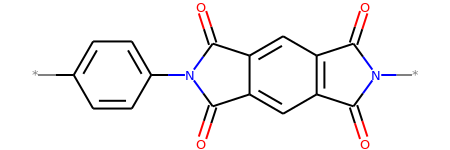

In [18]:
lp.mol

In [19]:
importlib.reload(retro)
retro.ring_close_retro(lp2)[4].mol

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


IndexError: list index out of range

In [ ]:
mol = intermed.mol #from above

In [21]:
g1,g2 = Chem.MolFromSmarts('[NH2]'),Chem.MolFromSmarts('*O*')

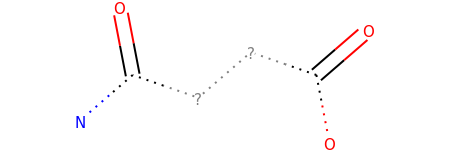

In [22]:
polymer_linkage = Chem.MolFromSmarts('[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]')
polymer_linkage

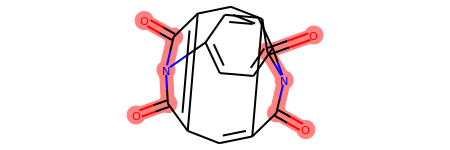

In [23]:
pm.mol

In [24]:
if type(mol) == str:
    mol = Chem.MolFromSmiles(mol)

lp = ru.LinearPol(mol)
pm = lp.PeriodicMol()
pm.GetSSSR()
if pm is None: #periodization failed
    #return None
    print('None1')
try: #sometimes g1 and g2 are given as lists. If so they will fail below.
    if pm.HasSubstructMatch(g1) or pm.HasSubstructMatch(g2): #chain should not have same functional groups we want to react
        if edit_function != nh_nco_edit: #but there are exceptions
            print('None2')
    g1 = [g1] #do this so symmetry check will have an iterable
    g2 = [g2] #do this so symmetry check will have an iterable
except:
    if any([pm.HasSubstructMatch(x) for x in g1] + [pm.HasSubstructMatch(x) for x in g2]): #chain should not have same functional groups we want to react
        if edit_function != nh_nco_edit: #but there are exceptions
            print('None3')      
matches=pm.GetSubstructMatches(polymer_linkage)
match_pairs = list(itertools.combinations(matches, 2))
new_mols = []

In [25]:
match_pair = match_pairs[0]

IndexError: list index out of range

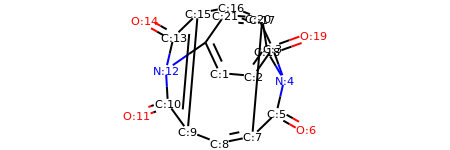

In [26]:
ru.mol_with_atom_index(pm.mol)

In [27]:
match_pair

NameError: name 'match_pair' is not defined

In [28]:
'[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]'

'[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]'

In [29]:
_,_,a_ioh,a_ic1,a_ic2,a_ico,_,a_in = match_pair[0]
_,_,b_ioh,b_ic1,b_ic2,b_ico,_,b_in = match_pair[1]

NameError: name 'match_pair' is not defined

In [30]:
bond_type = pm.mol.GetBondBetweenAtoms(a_ic1,a_ic2).GetBondType()
bond_type

NameError: name 'a_ic1' is not defined

In [31]:
em = Chem.EditableMol(pm.mol)
em.RemoveBond(a_ico,a_in)
em.RemoveBond(b_ico,b_in)

em.AddBond(a_ico,a_ioh,bond_type)
em.AddBond(b_ico,b_ioh,bond_type)

new_mol=em.GetMol()
Chem.SanitizeMol(new_mol)
new_mol

NameError: name 'a_ico' is not defined

In [32]:
importlib.reload(retro)
retro.sg_depolymerize(mol,polymer_linkage,retro.sg_rxns['[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]'][0])[0]

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


TypeError: 'NoneType' object is not subscriptable

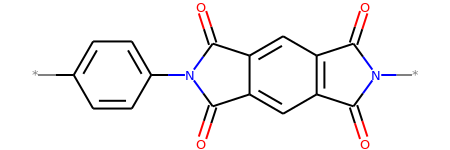

In [33]:
mol

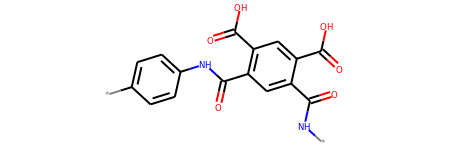

In [34]:
mol2 = Chem.MolFromSmiles('*NC(=O)c2cc(C(=O)Nc1ccc(*)cc1)c(C(=O)O)cc2C(=O)O')
mol2

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


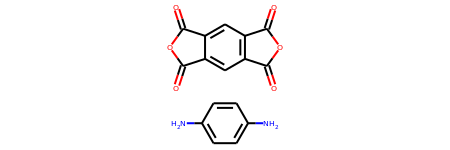

In [35]:
importlib.reload(retro)
retro.sg_depolymerize(mol2,polymer_linkage,retro.sg_rxns['[#6R0](=O)([OH])[C,c][C,c][CR1](=O)[NR1]'][0])[0]

In [36]:
retro.retrosynthesize([lps[4].SMILES],ro=False,radion=False,ox=False)

# Test multi-step retrosynthesis

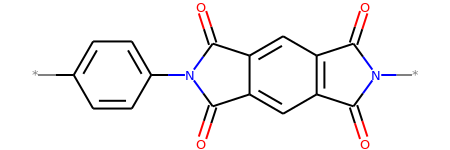

In [45]:
sm = '*c4ccc(n3c(=O)c2cc1c(=O)n(*)c(=O)c1cc2c3=O)cc4'
Chem.MolFromSmiles(sm)

In [41]:
importlib.reload(retro)
out=retro.retrosynthesize2([sm])

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


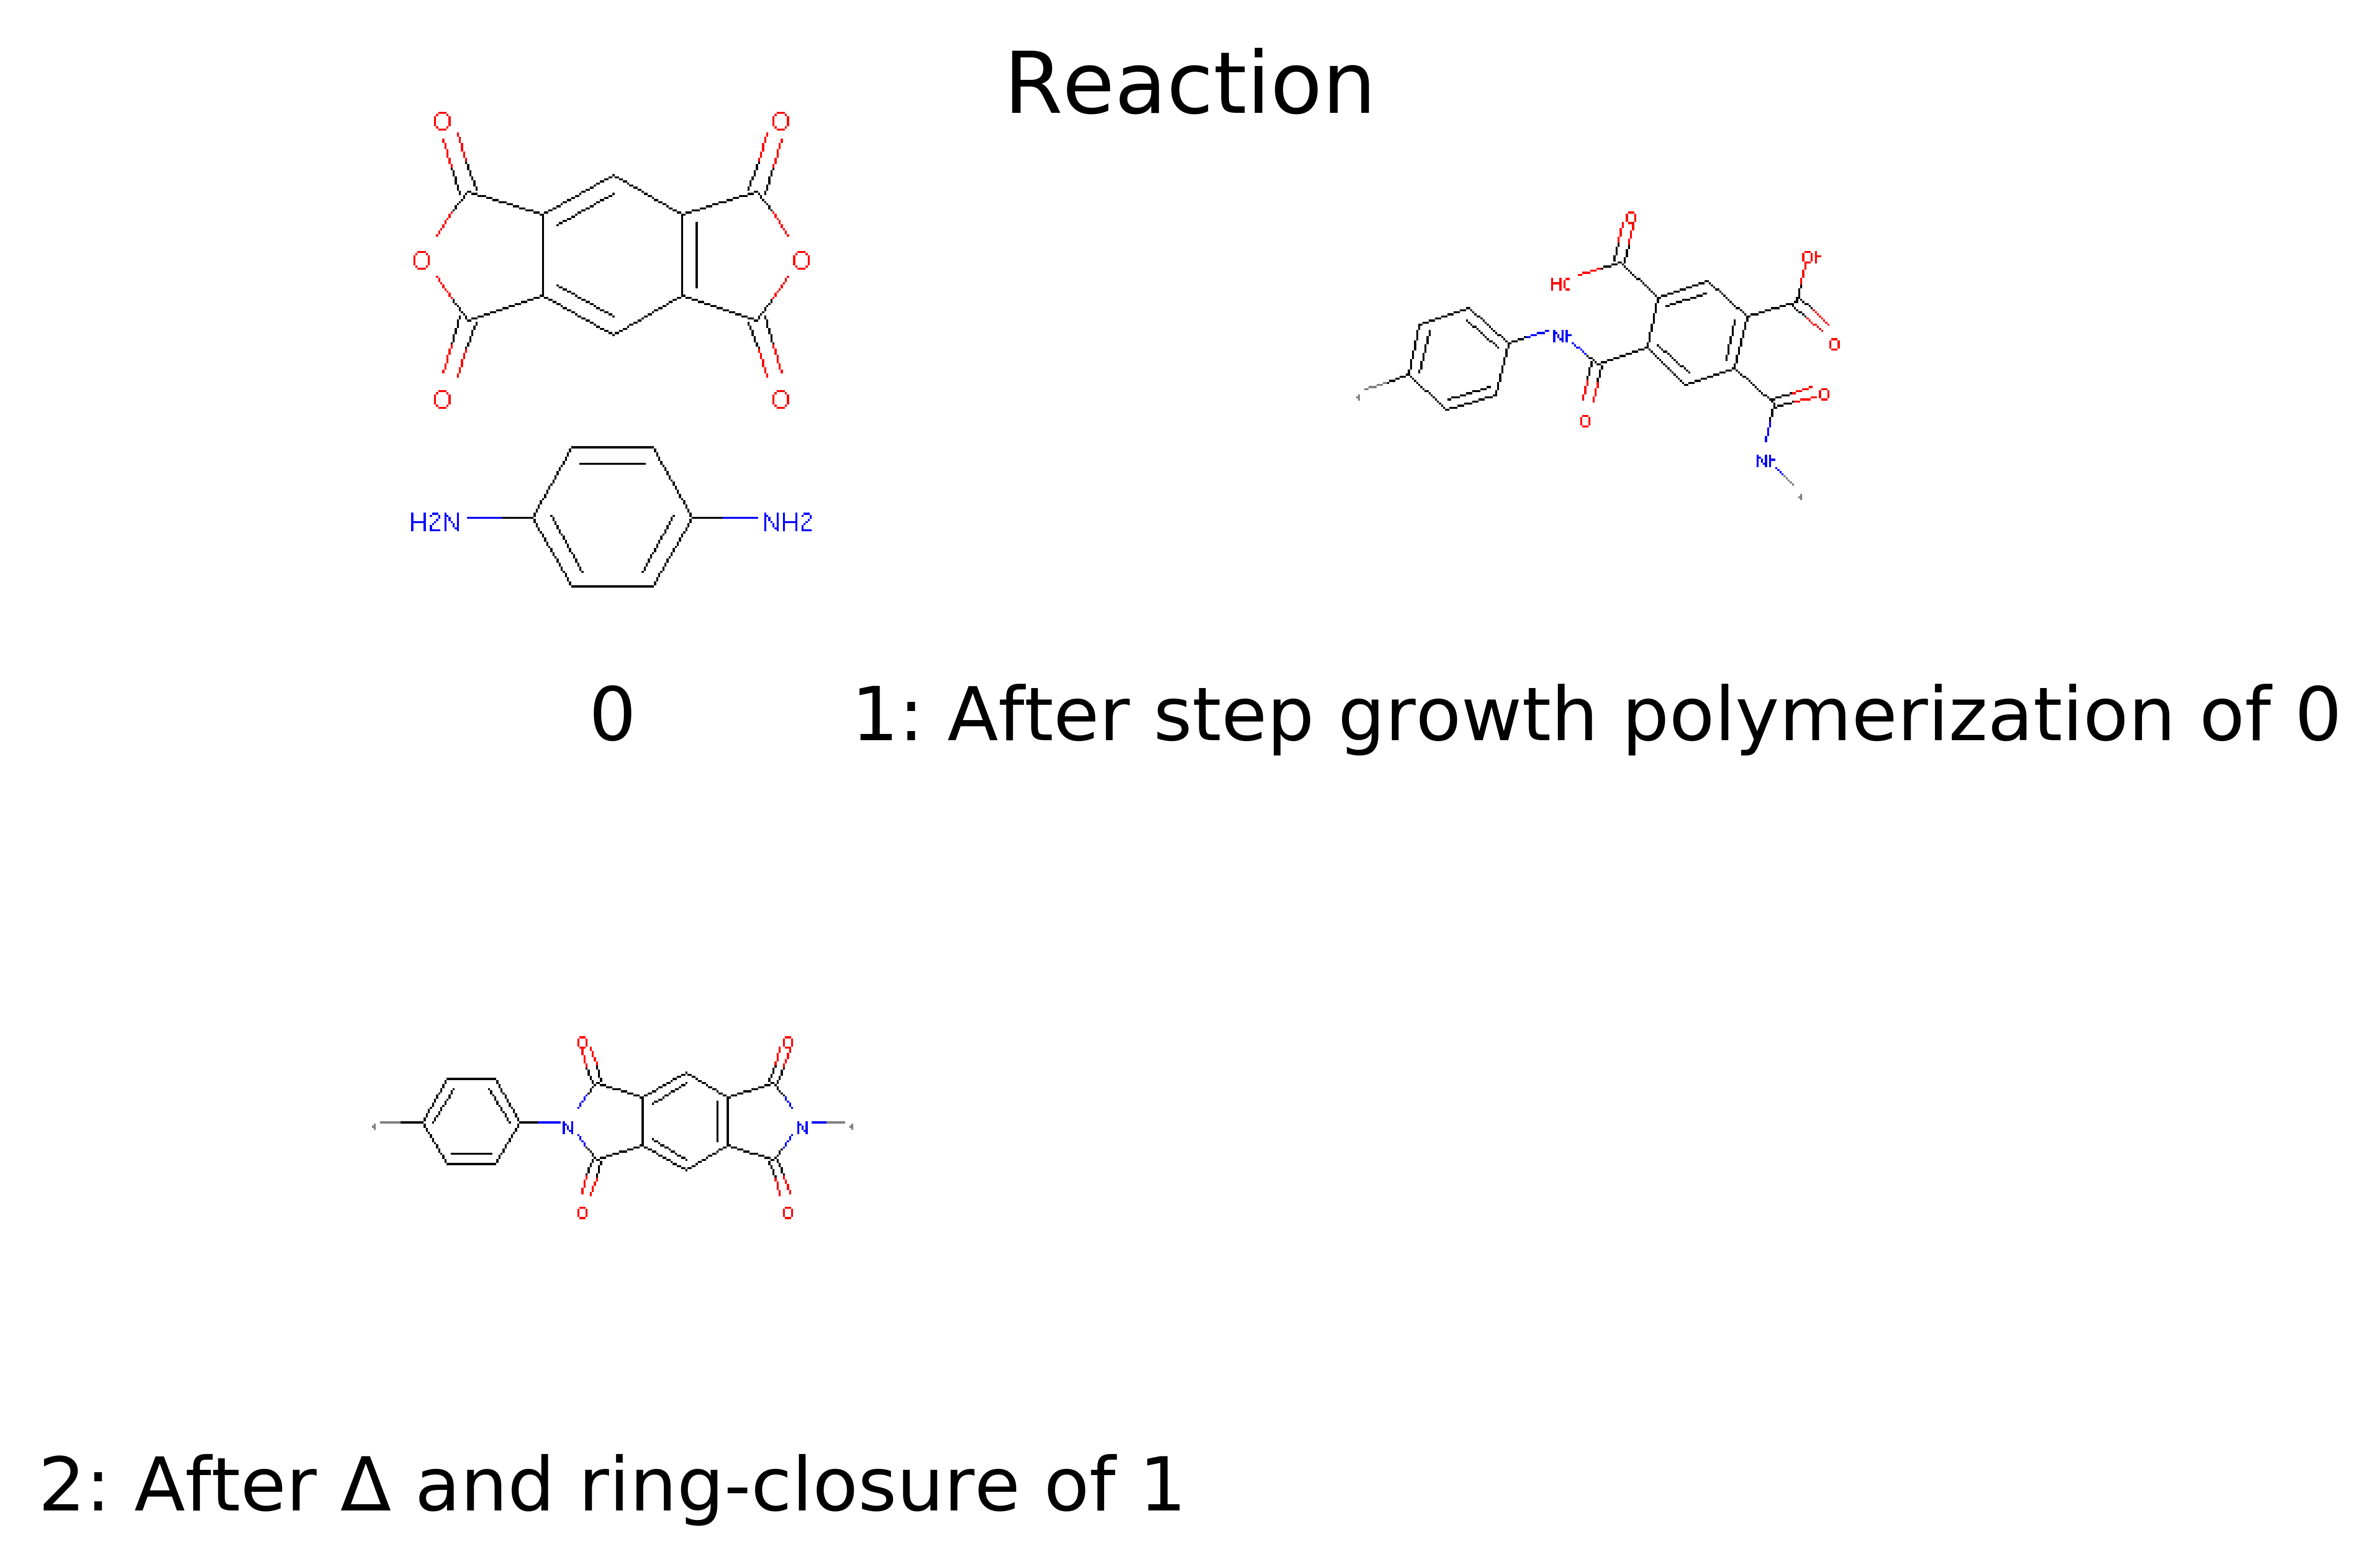

In [43]:
mpl.rcParams['figure.dpi']= 800
out[0].DrawSteps()

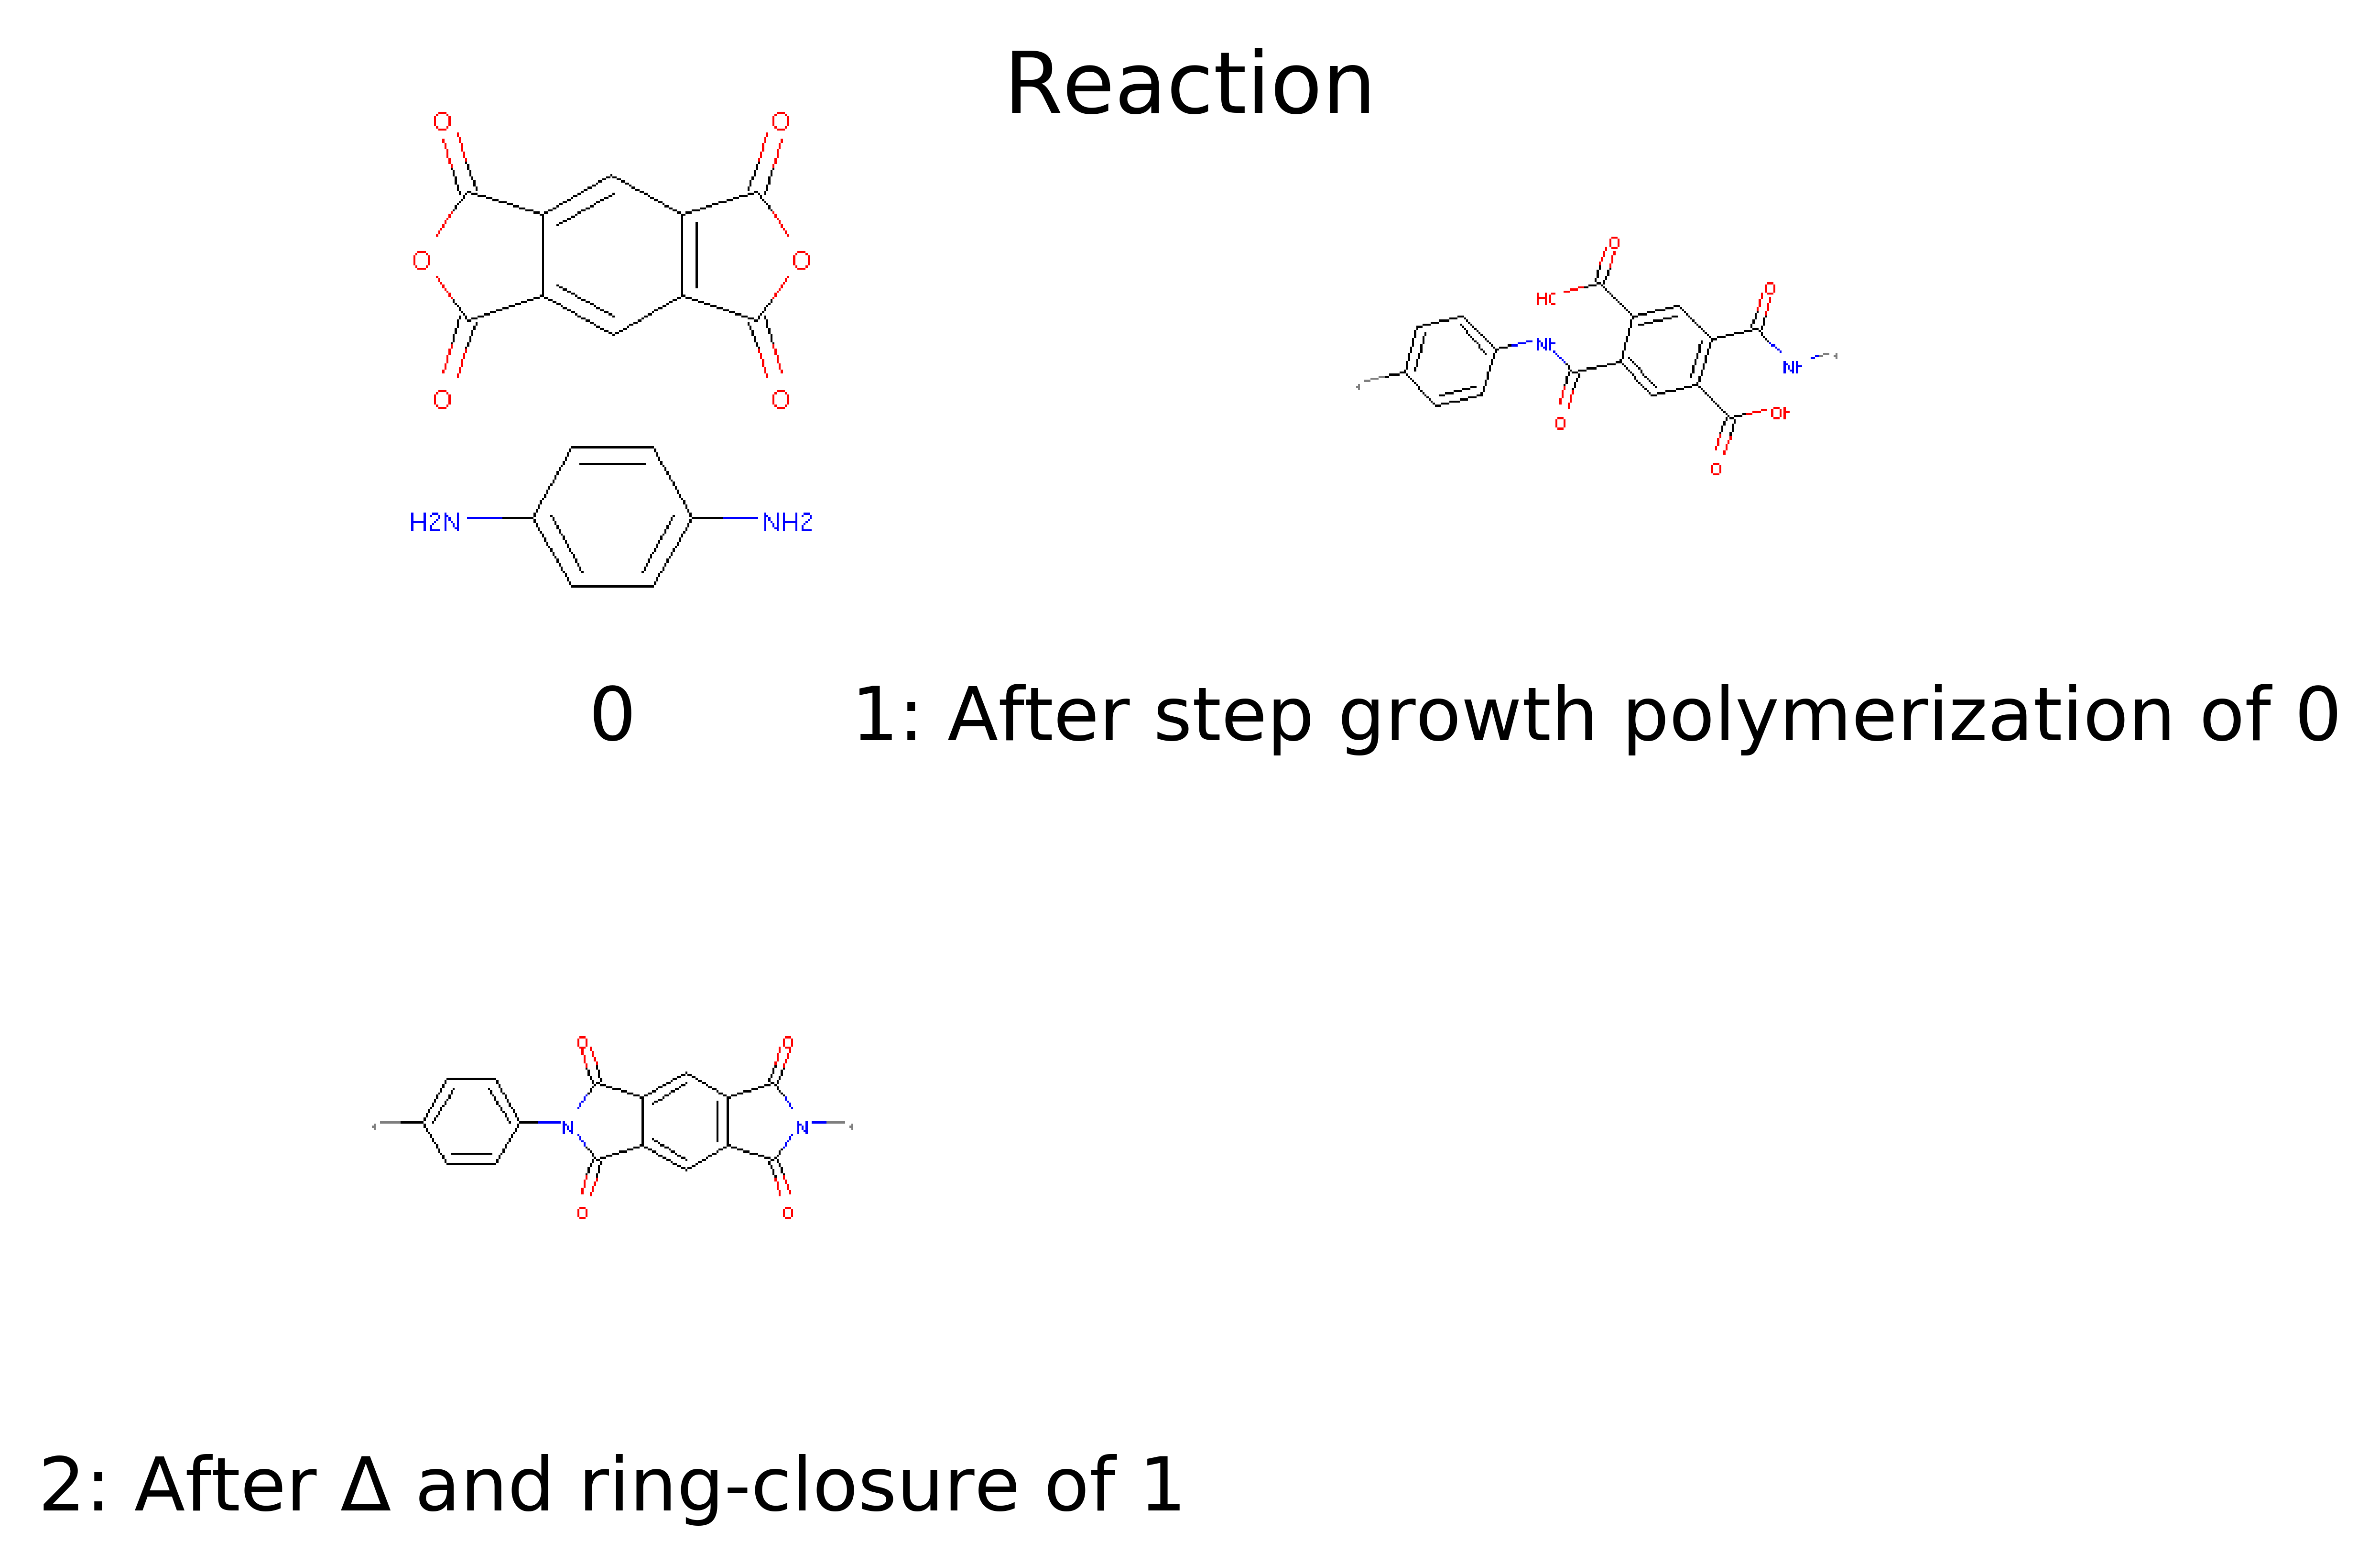

In [94]:
mpl.rcParams['figure.dpi']= 800
out[1].DrawSteps()

In [97]:
Chem.MolToSmiles(out[0].r_mols[-1])

'*NC(=O)c1cc(C(=O)Nc2ccc(*)cc2)c(C(=O)O)cc1C(=O)O'

In [98]:
Chem.MolToSmiles(out[1].r_mols[-1])

'*NC(=O)c1cc(C(=O)O)c(C(=O)Nc2ccc(*)cc2)cc1C(=O)O'

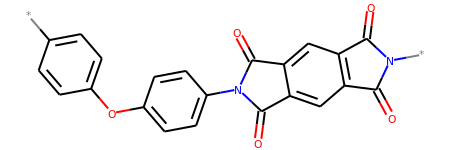

In [38]:
sm2 = '*c5ccc(Oc4ccc(n3c(=O)c2cc1c(=O)n(*)c(=O)c1cc2c3=O)cc4)cc5'
Chem.MolFromSmiles(sm2)

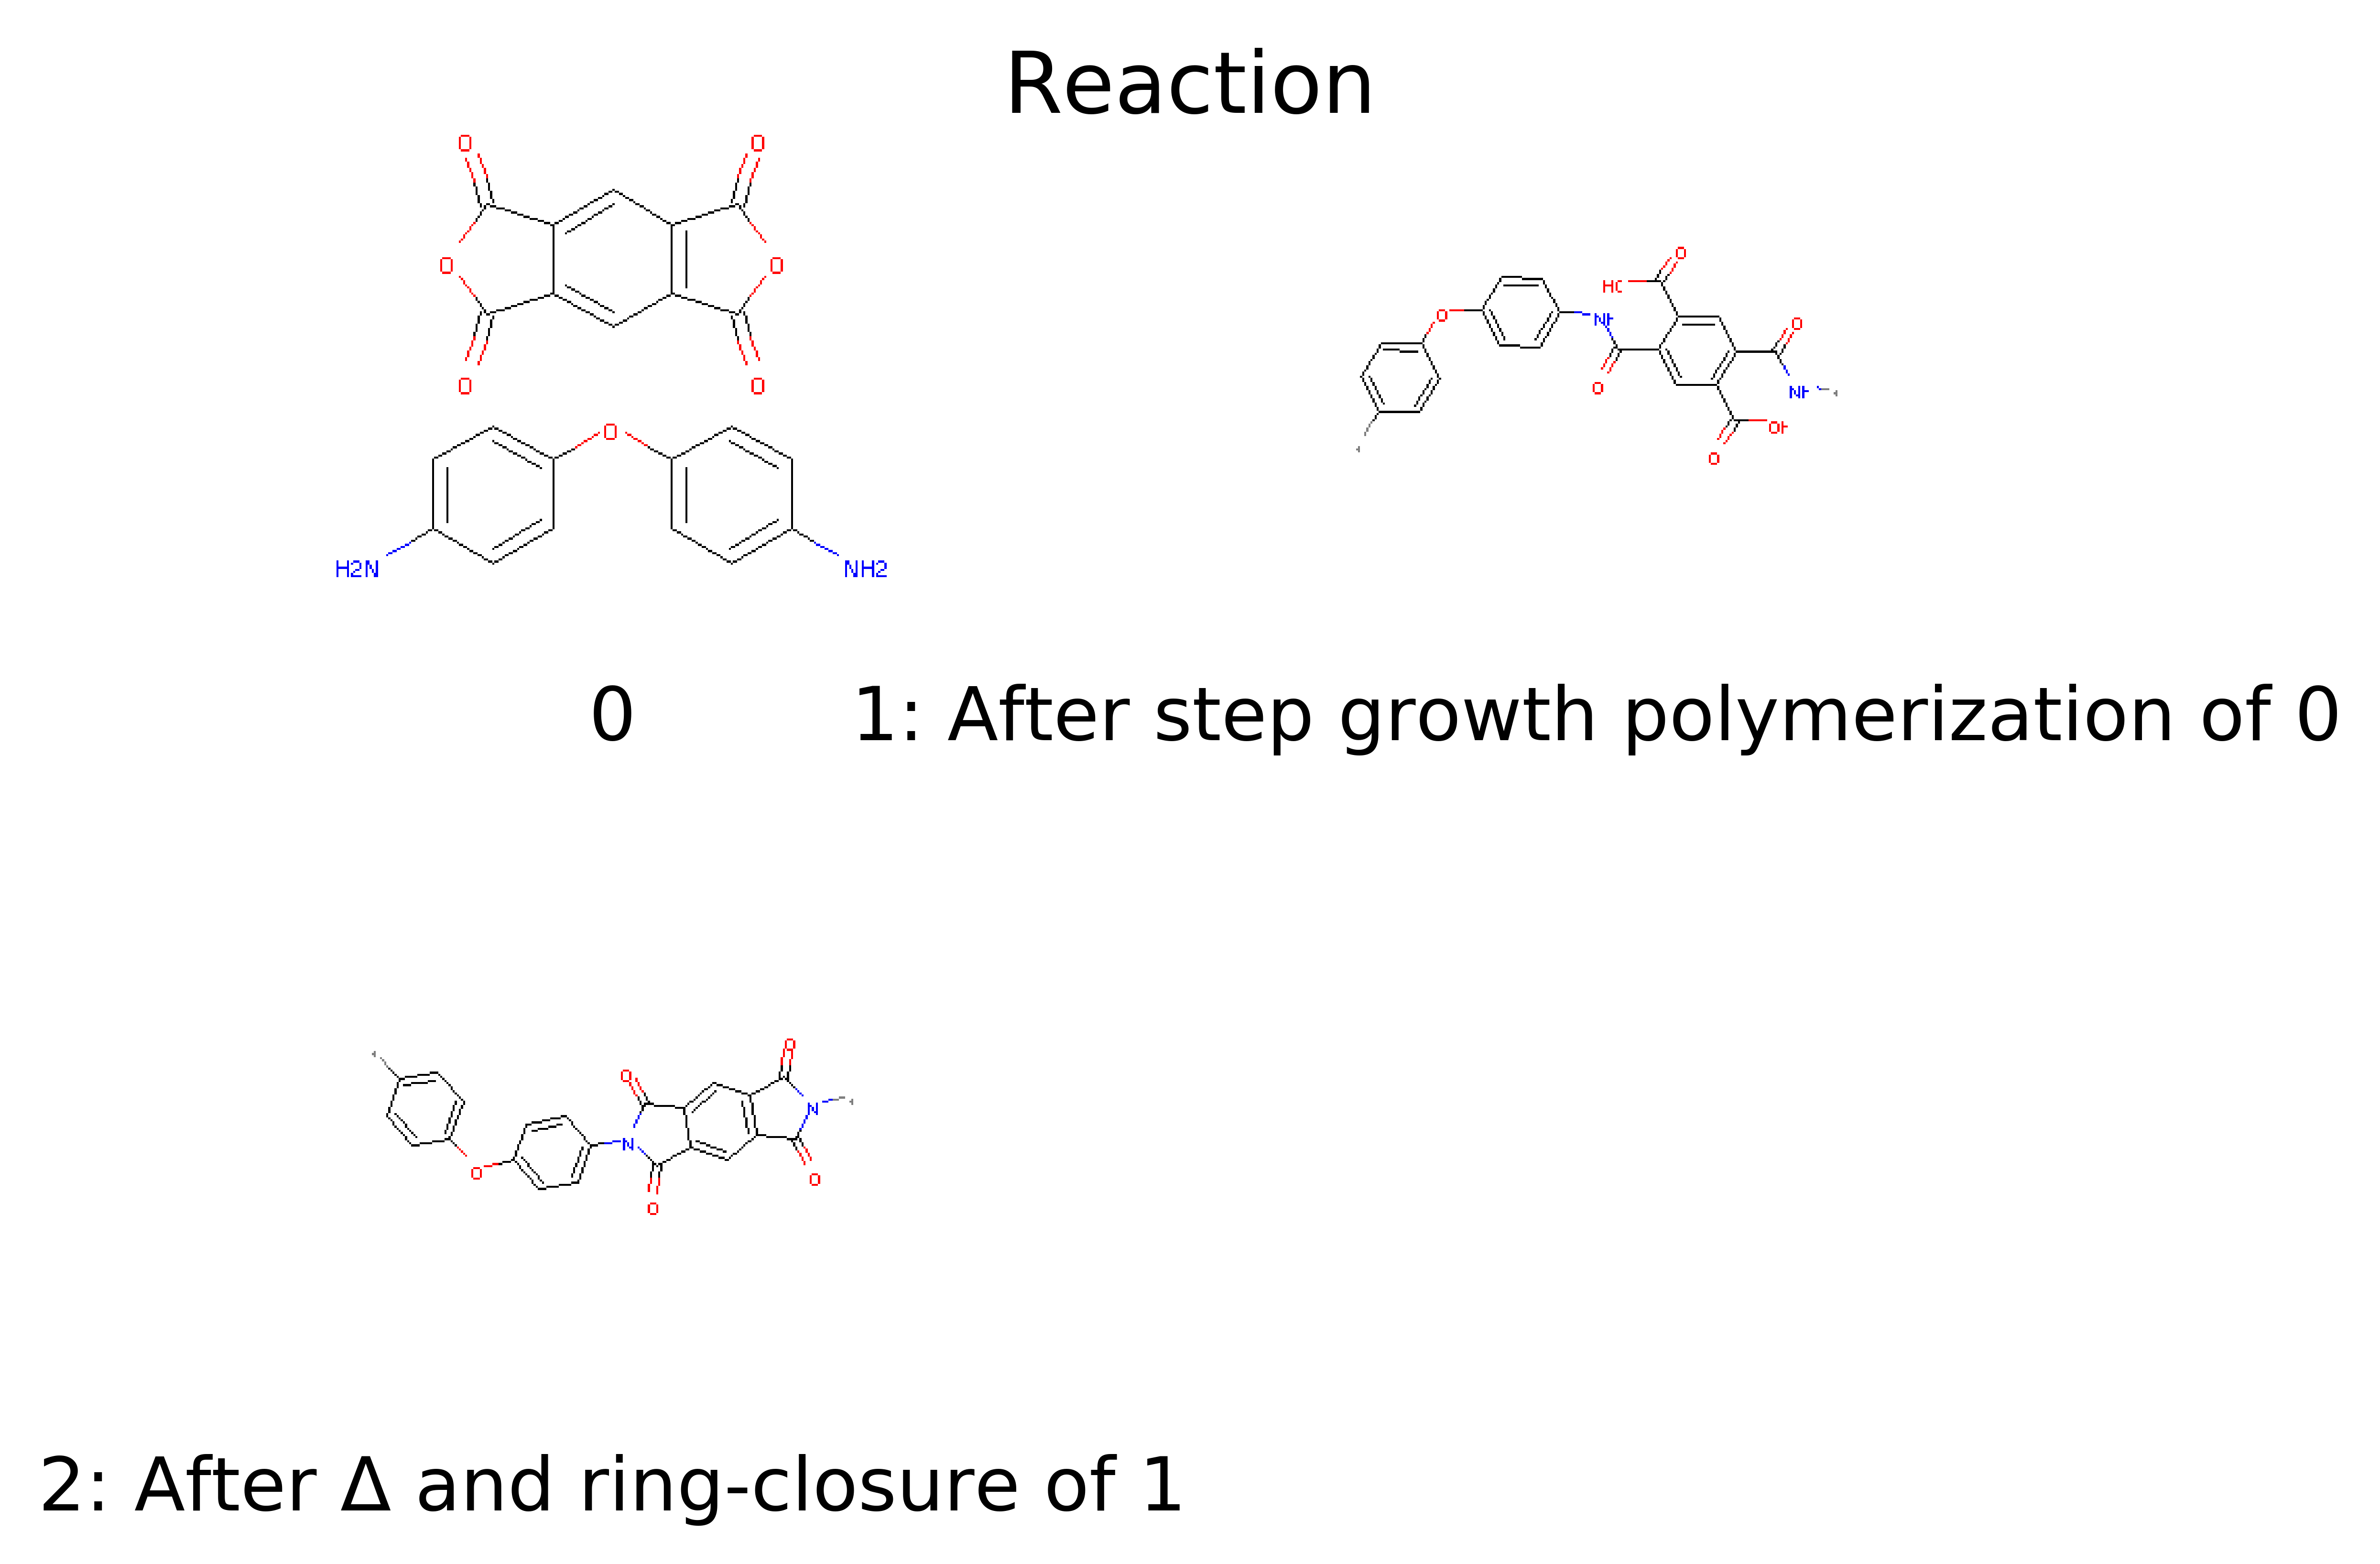

In [138]:
mpl.rcParams['figure.dpi']= 800
out[1].DrawSteps()

# Test if retrosynthesize2 and retrosynthesize yield same results

In [2]:
import random
import pickle

In [11]:
with open('/home/rgur/py_scripts/g2g_depolymerizable_05_31PM_on_January_09_2021.pkl','rb') as f:
    smiles_ls = pickle.load(f)

In [12]:
smiles_ls = random.sample(smiles_ls,200)
smiles_ls[0]

'[*]C(NC(=O)CC1([*])CCCC(C)C1)C1CCCC(CC(N)=O)C1'

In [170]:
importlib.reload(retro)
rxns = retro.retrosynthesize(smiles_ls,chain_reactions=True)

_RxnPaths len: 5
sm_RxnPaths len: 6
#######
[*]CC(=O)NC1COC(CO)C([*])(OC2OC(CO)C(O)C(O)C2NC(C)=O)C1
<function ring_close_retro at 0x7fb6243d6378>
inner_RxnPaths len: 0
<function func_chain_retro at 0x7fb6243b9f28>
inner_RxnPaths len: 0
<function hydrogenate_chain at 0x7fb622e05bf8>
inner_RxnPaths len: 8
sm_RxnPaths len: 9
#######
[*]C1(CC(=O)NC2COC(OC3OC(CO)C(N)C([*])(O)C3N)CC2O)CCCC(C)C1
<function ring_close_retro at 0x7fb6243d6378>
inner_RxnPaths len: 0
<function func_chain_retro at 0x7fb6243b9f28>
inner_RxnPaths len: 0
<function hydrogenate_chain at 0x7fb622e05bf8>
inner_RxnPaths len: 7
sm_RxnPaths len: 8
#######
[*]C1C2CC(=O)CC2CC1C1([*])NCC2C(C(=O)OCC3CC4CCC3C4)C3CC(=O)CC3C21
<function ring_close_retro at 0x7fb6243d6378>
inner_RxnPaths len: 0
<function func_chain_retro at 0x7fb6243b9f28>
inner_RxnPaths len: 0
<function hydrogenate_chain at 0x7fb622e05bf8>
inner_RxnPaths len: 1
sm_RxnPaths len: 2
#######
[*]COC(=O)C1(C)CC2CC1C1CCC(CCC3C(C)CC4C3C3CC4C(C)(C(=O)OC)C3)C21[*]
<function 

In [171]:
len(rxns)

703

In [65]:
two_step = [x for x in rxns if x.GetNSteps()==2]

In [66]:
len(two_step)

548

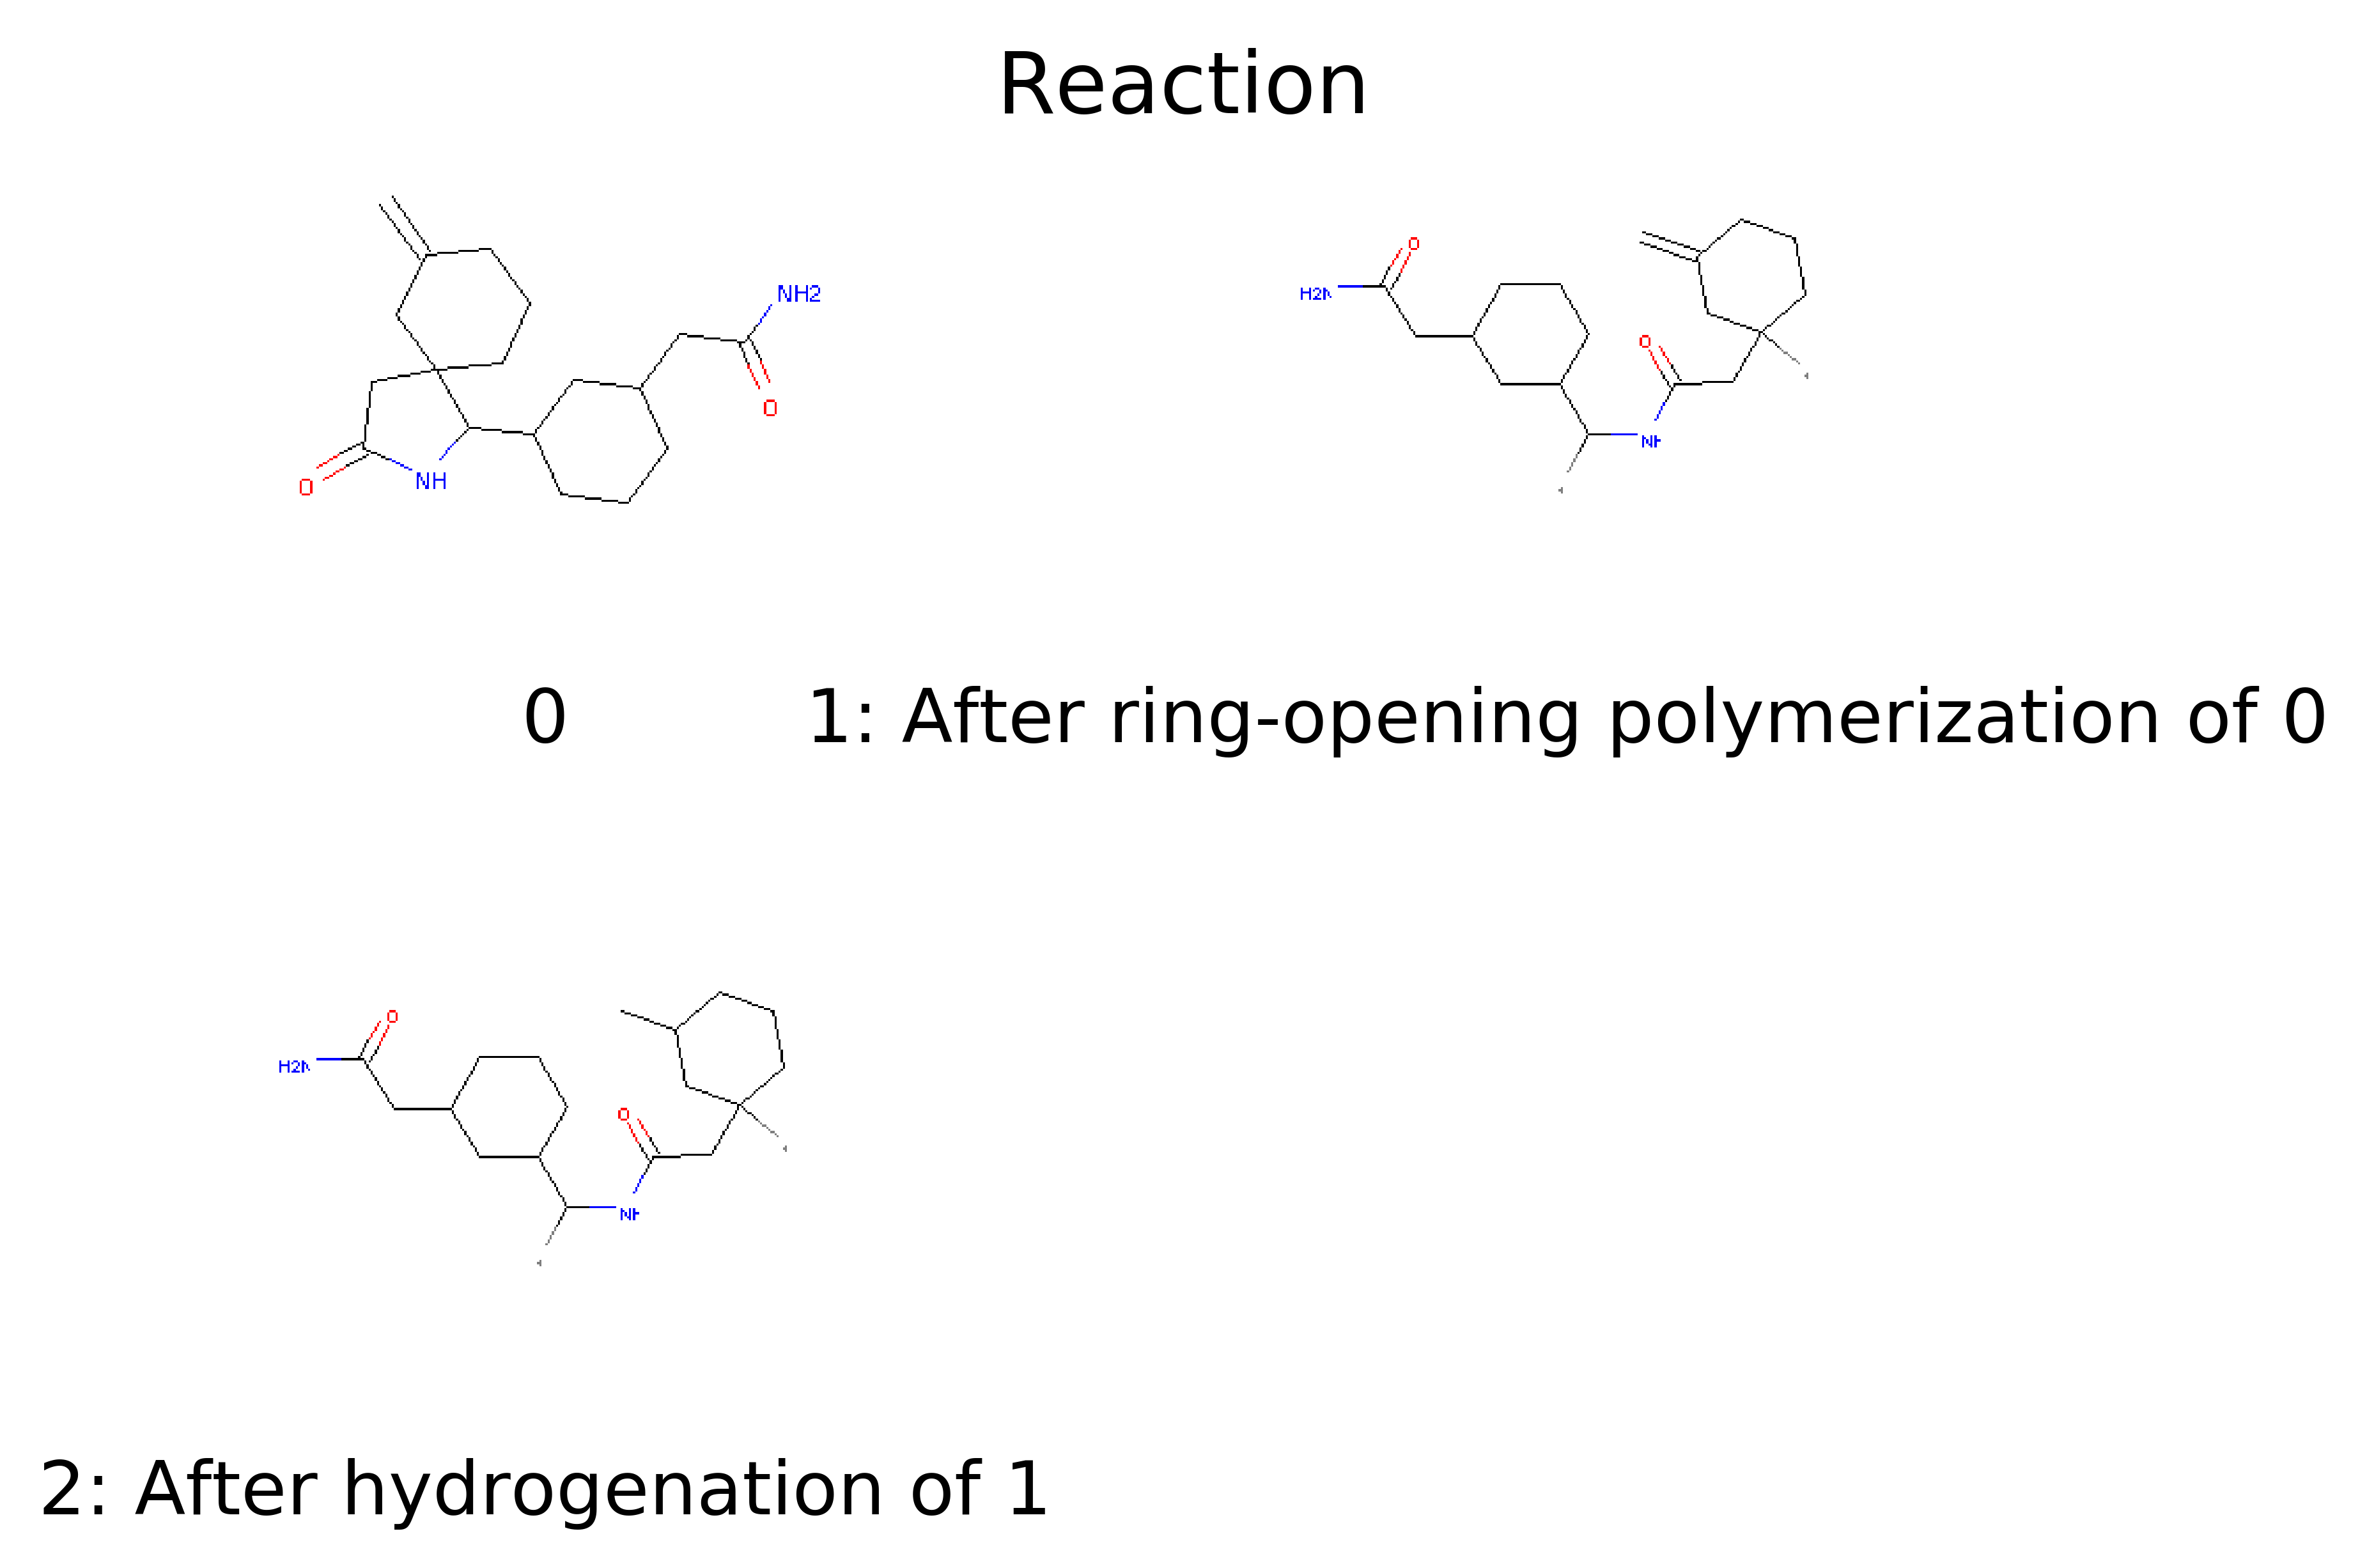

In [68]:
mpl.rcParams['figure.dpi']= 600
rxns[1].DrawSteps()

In [61]:
rxns[0].reaction_step_ls[0].rxn_fn_hash

<function fall20_mse_8803.ro_depolymerize(lp, ro_linkage_key, selectivity=False)>

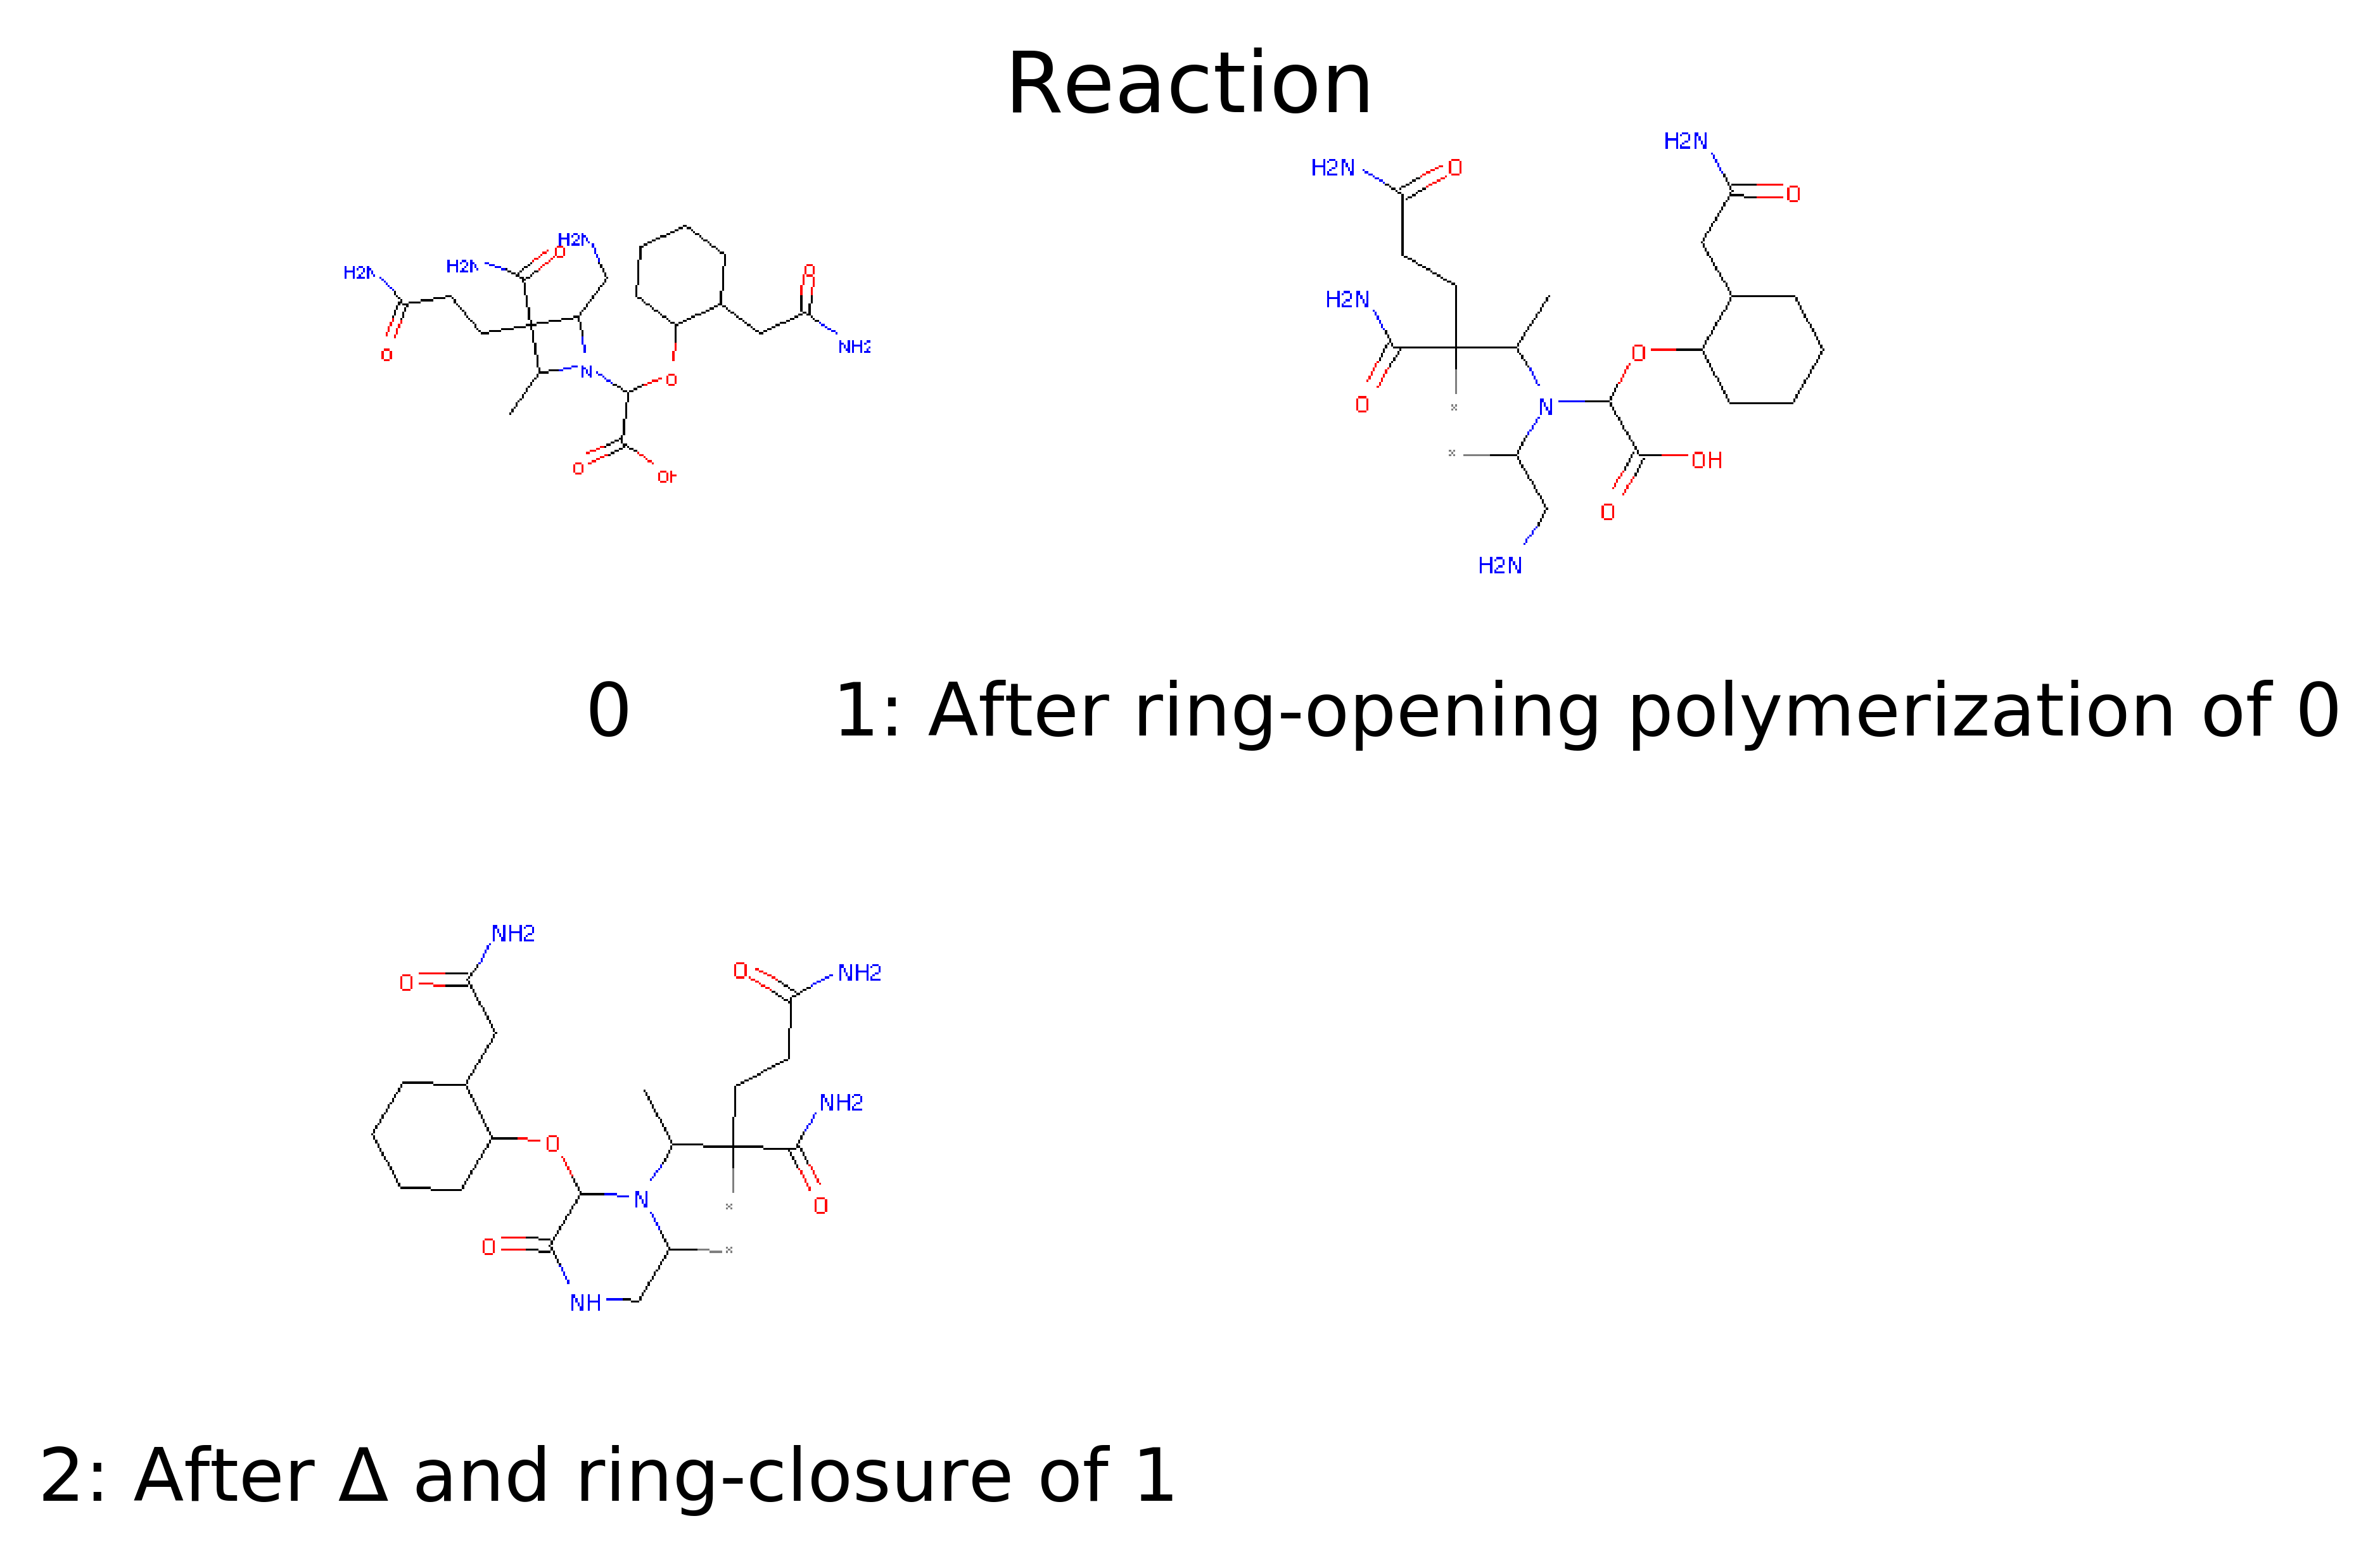

In [79]:
mpl.rcParams['figure.dpi']= 600
two_step[2].DrawSteps()

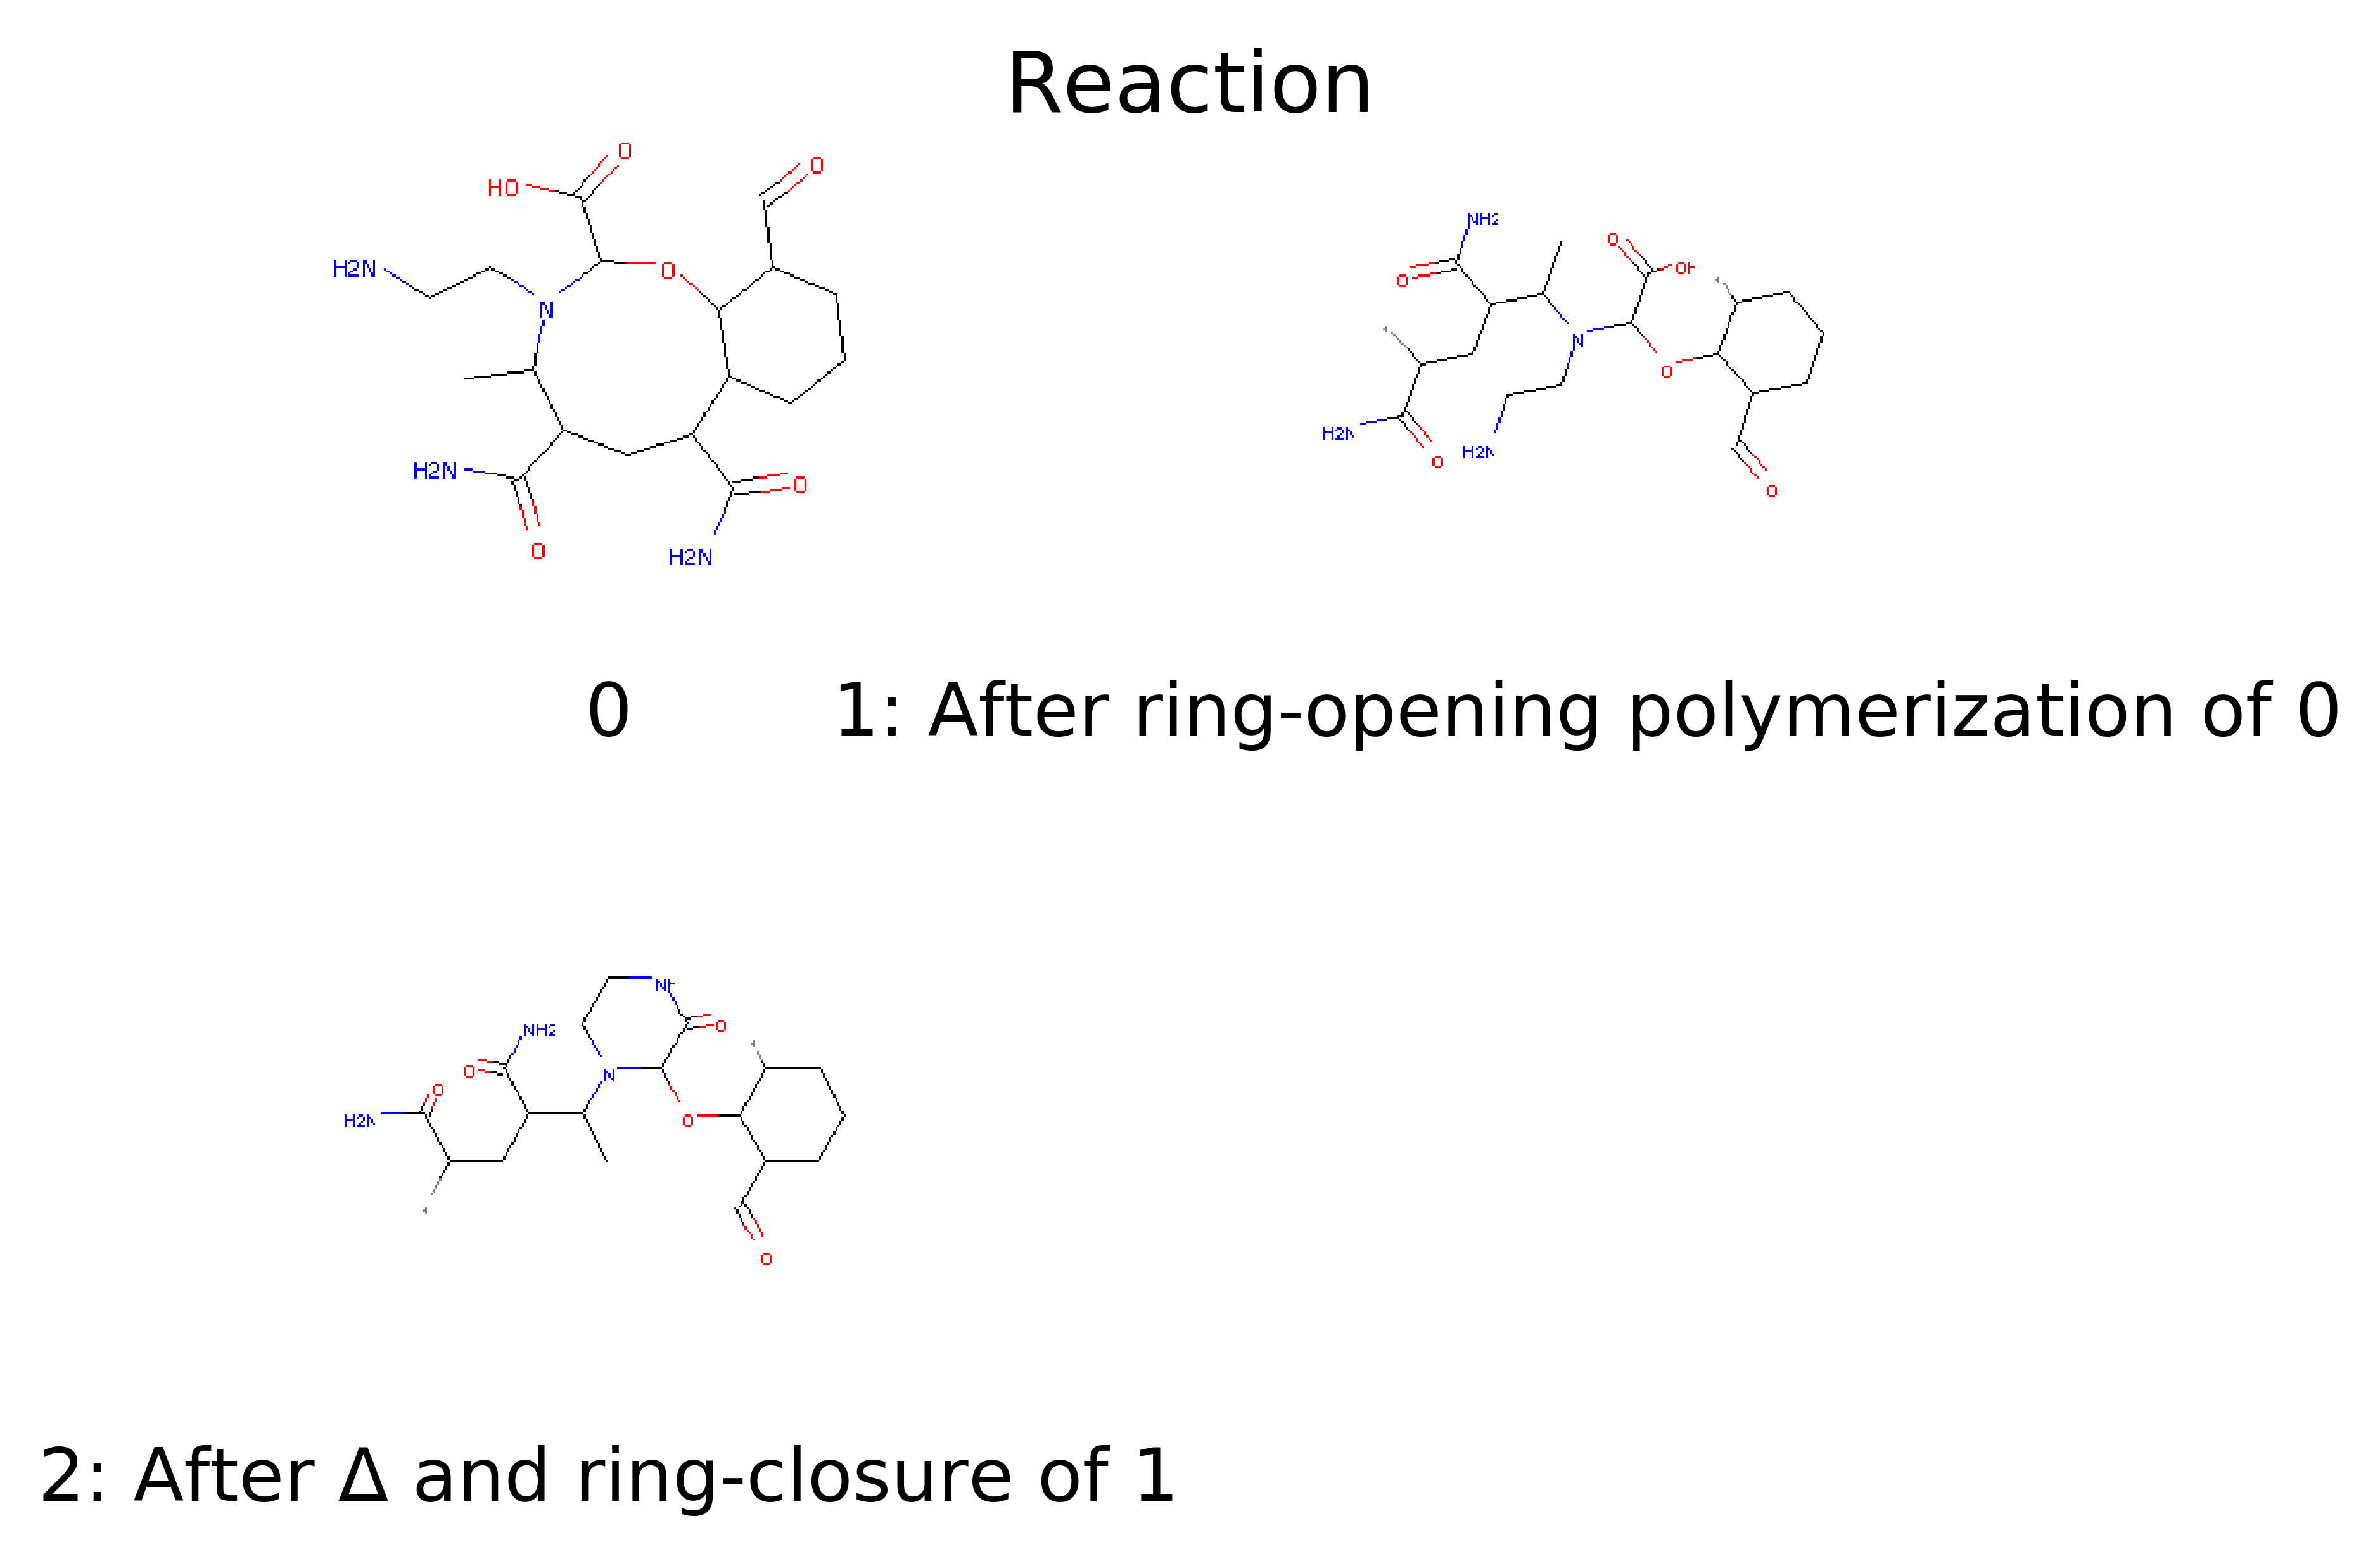

In [86]:
mpl.rcParams['figure.dpi']= 600
two_step[9].DrawSteps()

# Test functionalization of PBI

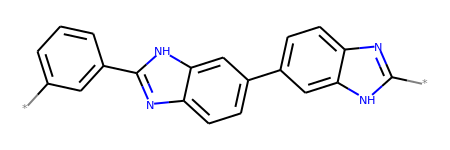

In [2]:
sm = '*c5cccc(c4nc3ccc(c2ccc1nc(*)[nH]c1c2)cc3[nH]4)c5'
pbi_mol = Chem.MolFromSmiles(sm)
pbi_mol

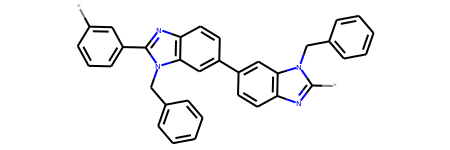

In [292]:
mol = Chem.MolFromSmiles('[*]C1=CC(=CC=C1)C6=NC2=C(C=C(C=C2)C3=CC4=C(C=C3)N=C([*])[N]4CC5=CC=CC=C5)[N]6CC7=CC=CC=C7')
mol

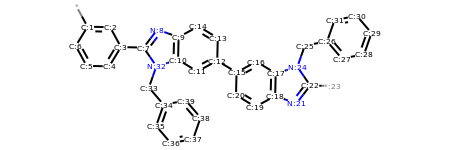

In [4]:
ru.mol_with_atom_index(mol)

RDKit ERROR: [13:25:07] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 25
RDKit ERROR: 


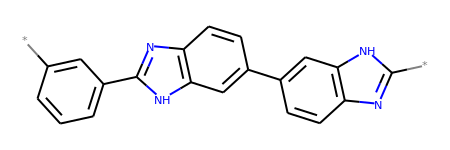

In [5]:
importlib.reload(ru)
lp = ru.LinearPol(mol)
rxn = 'nitro_base'
if rxn == 'nitro_base':
    r_mol = lp.MainChainMol()#reduced mol 
ru.mol_without_atom_index(r_mol.mol)

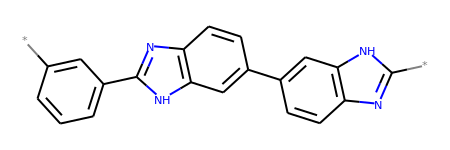

In [6]:
if rxn != 'nitro_base':
    r_mol = r_mol.PeriodicMol()
ru.mol_without_atom_index(r_mol.mol)

In [306]:
lp2.SMILES

'*c1cccc(-c2nc3ccc(-c4ccc5nc(*)n(CCc6ccccc6)c5c4)cc3n2Cc2ccccc2)c1'

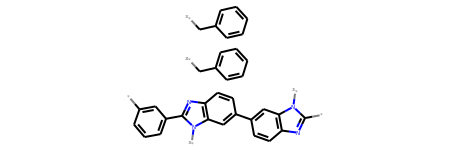

In [293]:
lp = ru.LinearPol(mol)
#lp = lp2
replace_group = Chem.MolFromSmarts('n[*R0]')
matches=lp.mol.GetSubstructMatches(replace_group)
matches = [set(m) for m in matches]
frag_mol=Chem.FragmentOnBonds(lp.mol,[lp.mol.GetBondBetweenAtoms(i,j).GetIdx() for i,j in matches])
ru.mol_without_atom_index(frag_mol)

In [294]:
frag_mols = Chem.GetMolFrags(frag_mol)[1:]
frag_mols

((25, 26, 27, 28, 29, 30, 31, 40), (33, 34, 35, 36, 37, 38, 39, 42))

In [295]:
all_atoms = set(range(lp.mol.GetNumAtoms()))

In [238]:
keep_atoms = all_atoms.union([x for x in frag_mols[0] if x < lp.mol.GetNumAtoms()])

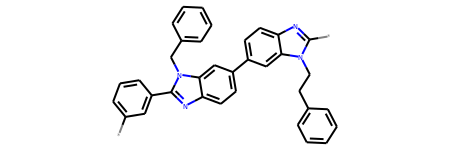

In [239]:
lp.SubChainMol(lp.mol,[lp.mol.GetAtomWithIdx(x) for x in keep_atoms])

In [223]:
frag_mol.HasSubstructMatch(Chem.MolFromSmarts('[24#0]'))

True

In [296]:
# try to generalize above
unique_frags = {}#SMILES - list of atom matches
frag_ls = Chem.MolToSmiles(ru.mol_without_atom_index(frag_mol)).split('.')[1:]
frag_ls = [re.sub('\[[0-9]+\*\]','*',s) for s in frag_ls]
frag_ls

['*Cc1ccccc1', '*Cc1ccccc1']

In [297]:
for i,s in enumerate(frag_ls):
    if s not in unique_frags:
        unique_frags[s] = list(frag_mols[i])
    else:
        unique_frags[s].extend(frag_mols[i])
unique_frags

{'*Cc1ccccc1': [25,
  26,
  27,
  28,
  29,
  30,
  31,
  40,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  42]}

In [298]:
mols = []
for L in range( 1,len(unique_frags.keys())+1 ):
    for combo in itertools.combinations(unique_frags.values(),L):
        combo_matches = set(ru.flatten_ll(combo))
        print(combo_matches)
        all_atoms = set(range(lp.mol.GetNumAtoms()))
        keep_atoms = all_atoms.difference(combo_matches)
        mols.append( lp.SubChainMol(lp.mol,[lp.mol.GetAtomWithIdx(x) for x in keep_atoms]) )
mols

{33, 34, 35, 36, 37, 38, 39, 40, 42, 25, 26, 27, 28, 29, 30, 31}
RDKit ERROR: [18:02:55] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 25
RDKit ERROR: 


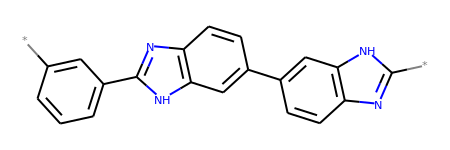

In [299]:
mols[0]

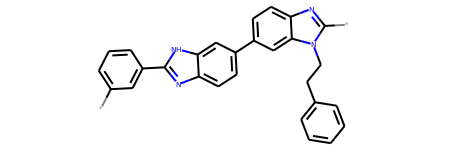

In [290]:
mols[1]

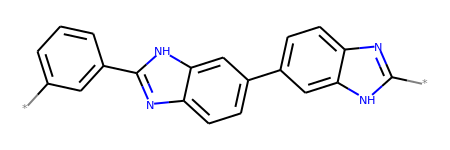

In [291]:
mols[2]

# Test func_chain_retro

In [304]:
importlib.reload(retro)
importlib.reload(ru)
mol = Chem.MolFromSmiles('[*]C1=CC(=CC=C1)C6=NC2=C(C=C(C=C2)C3=CC4=C(C=C3)N=C([*])[N]4CC5=CC=CC=C5)[N]6CC7=CC=CC=C7')
lp = ru.LinearPol(mol)
out=retro.func_chain_retro(lp)
out

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
{33, 34, 35, 36, 37, 38, 39, 40, 42, 25, 26, 27, 28, 29, 30, 31}
RDKit ERROR: [18:09:31] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 25
RDKit ERROR: 


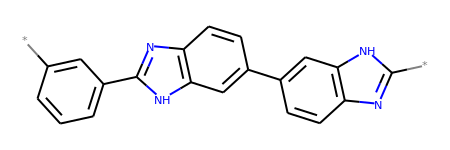

In [305]:
out[0]

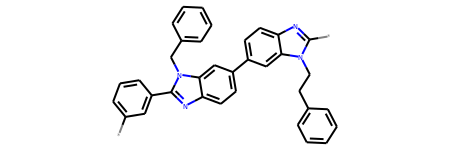

In [307]:
lp = ru.LinearPol('*c1cccc(-c2nc3ccc(-c4ccc5nc(*)n(CCc6ccccc6)c5c4)cc3n2Cc2ccccc2)c1')
lp.mol


In [308]:
out=retro.func_chain_retro(lp)
out

{41, 20, 21, 22, 23, 24, 25, 26, 27}
{33, 34, 35, 36, 37, 38, 39, 43}
{33, 34, 35, 36, 37, 38, 39, 41, 43, 20, 21, 22, 23, 24, 25, 26, 27}
RDKit ERROR: [18:10:45] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 19 20 21
RDKit ERROR: 
RDKit ERROR: [18:10:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 30 31 32
RDKit ERROR: 
RDKit ERROR: [18:10:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 22 23 24
RDKit ERROR: 


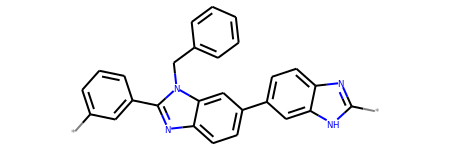

In [309]:
out[0]

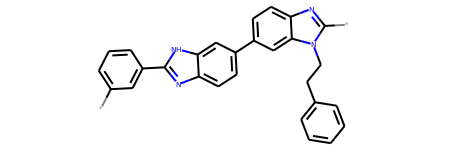

In [310]:
out[1]

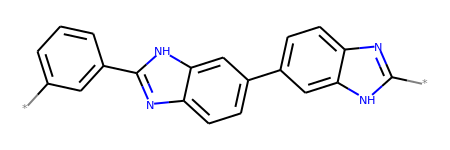

In [311]:
out[2]

# Make hydrogenate chain

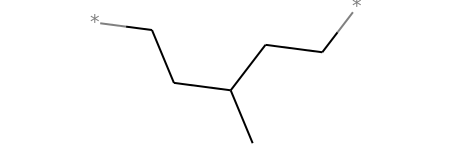

In [2]:
mol = Chem.MolFromSmiles('[*]CCC(C)CC[*]')
mol

In [3]:
lp = ru.LinearPol(mol)


In [4]:
importlib.reload(retro)
out = retro.hydrogenate_chain(lp)
out

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
n_single_bonds:  4
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:58:08] Explicit valence for atom # 3 C, 5, is greater than perm

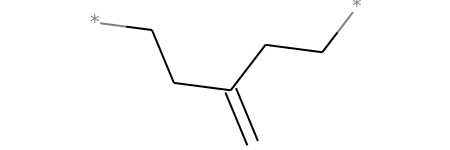

In [5]:
out[2]

In [9]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
importlib.reload(retro)
retro.retrosynthesize([Chem.MolToSmiles(out[2])])

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
#######
<function ring_close_retro at 0x7f166f866158>
RxnSteps len: 0
Unique RxnSteps len: 0
inner_RxnPaths len: 0
sm_RxnPaths len: 1
#######
<function func_chain_retro at 0x7f166f872bf8>
RxnSteps len: 0
Unique RxnSteps len: 0
inner_RxnPaths len: 0
sm_RxnPaths len: 1
#######
<function hydrogenate_chain at 0x7f166f8722f0>
n_single_bonds:  4
RxnSteps len: 3
Unique RxnSteps len: 2
inner_RxnPaths len: 2
sm_RxnPaths len: 3


[]

# Look into alternate paths for synthesis of RID: R1003252

In [159]:
importlib.reload(retro)
out = retro.retrosynthesize(['[*]OC1C(C)(C)C(OC([*])=O)C1(C)C'],dimerize=True)
out

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
#######
[*]OC1C(C)(C)C(OC([*])=O)C1(C)C
<function ring_close_retro at 0x7fb6243b9378>
inner_RxnPaths len: 0
<function func_chain_retro at 0x7fb6269376a8>
inner_RxnPaths len: 0
<function hydrogenate_chain at 0x7fb624f51840>
inner_RxnPaths len: 0
sm_RxnPaths len: 2


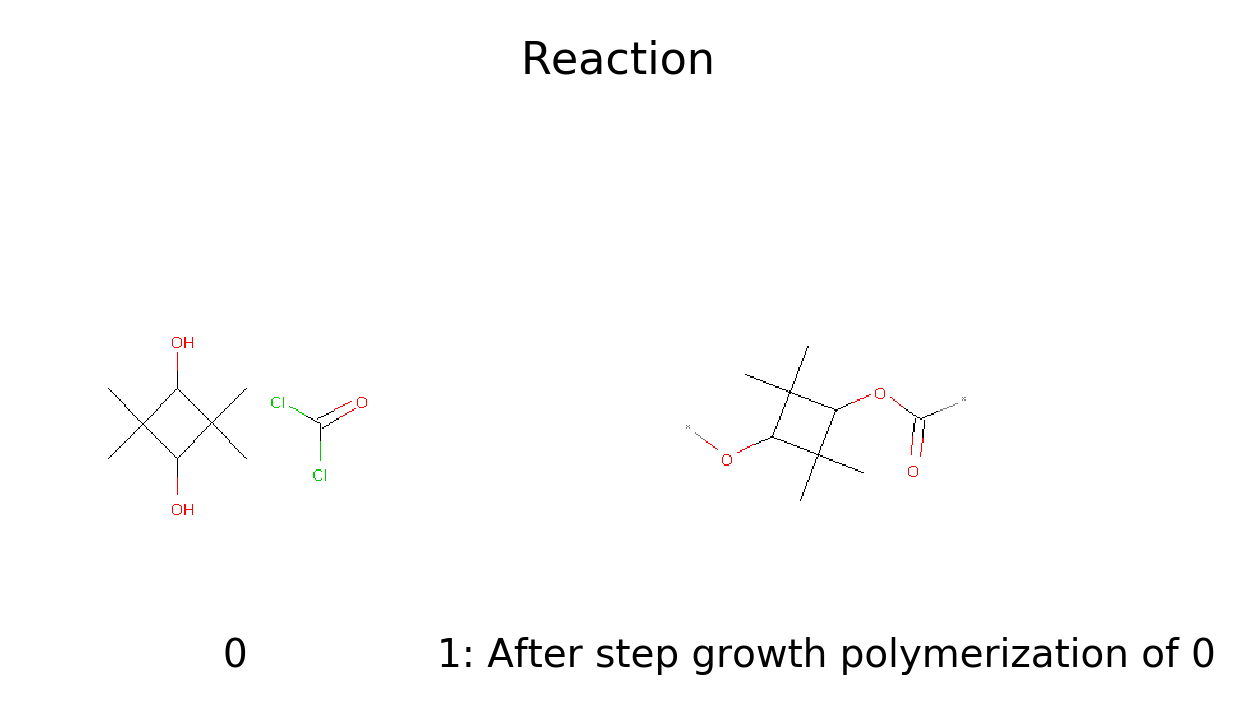

In [160]:
mpl.rcParams['figure.dpi']= 400
out[0].DrawSteps((3,2))

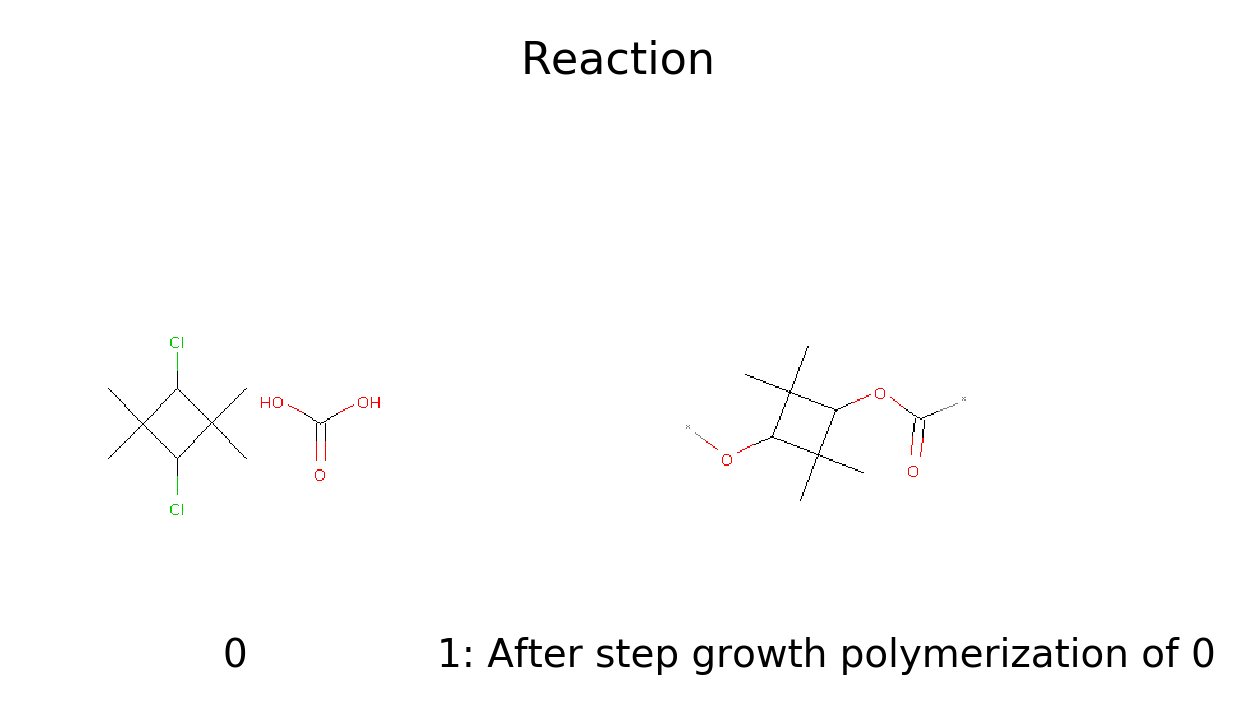

In [161]:
mpl.rcParams['figure.dpi']= 400
out[1].DrawSteps((3,2))

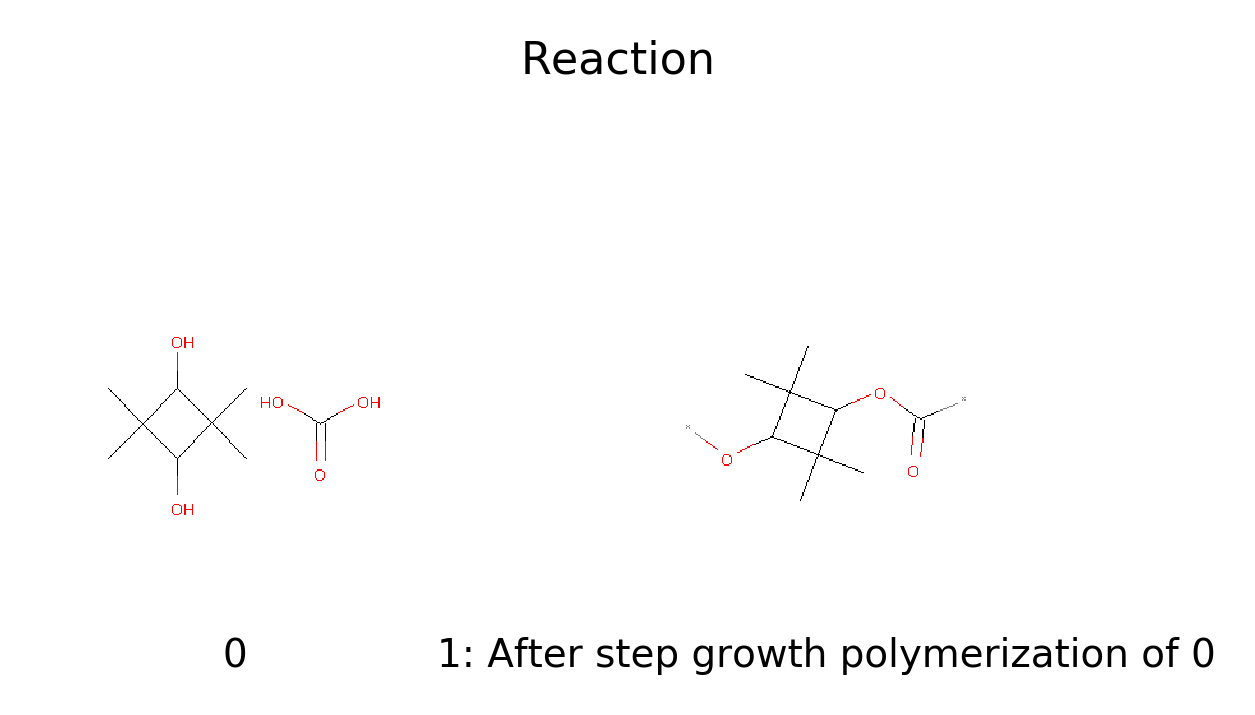

In [162]:
mpl.rcParams['figure.dpi']= 400
out[2].DrawSteps((3,2))

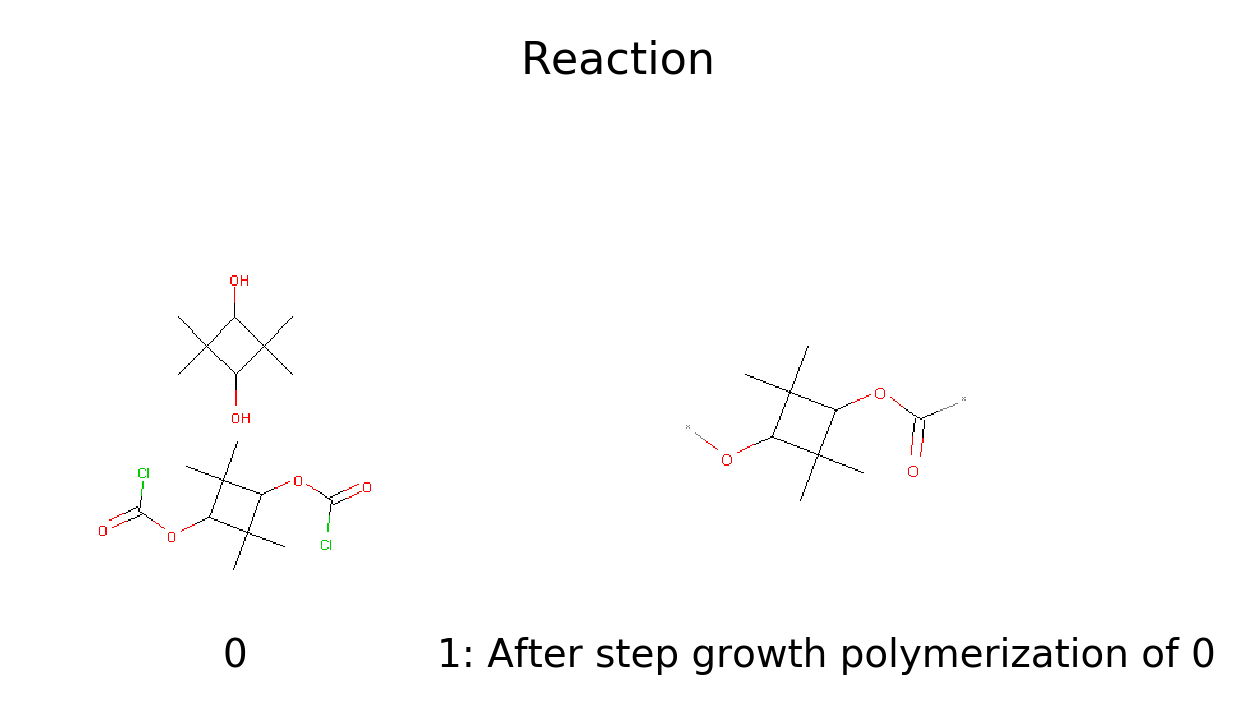

In [163]:
mpl.rcParams['figure.dpi']= 400
out[3].DrawSteps((3,2))

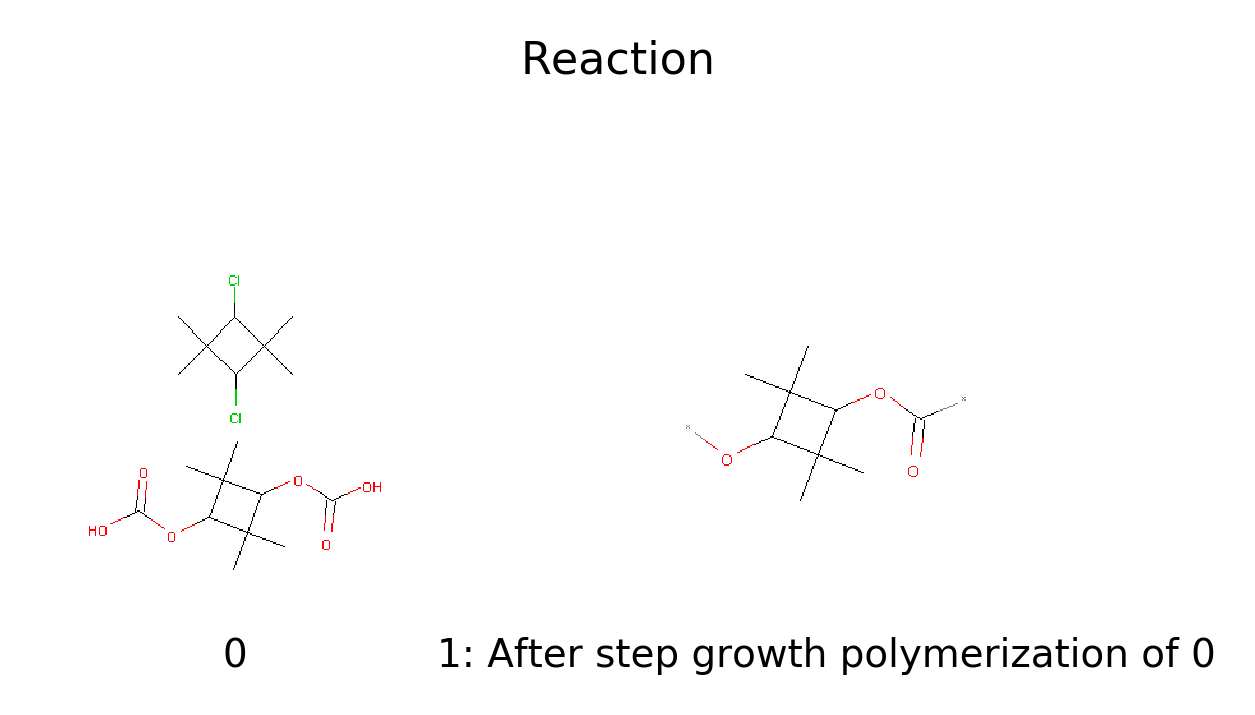

In [164]:
mpl.rcParams['figure.dpi']= 400
out[4].DrawSteps((3,2))

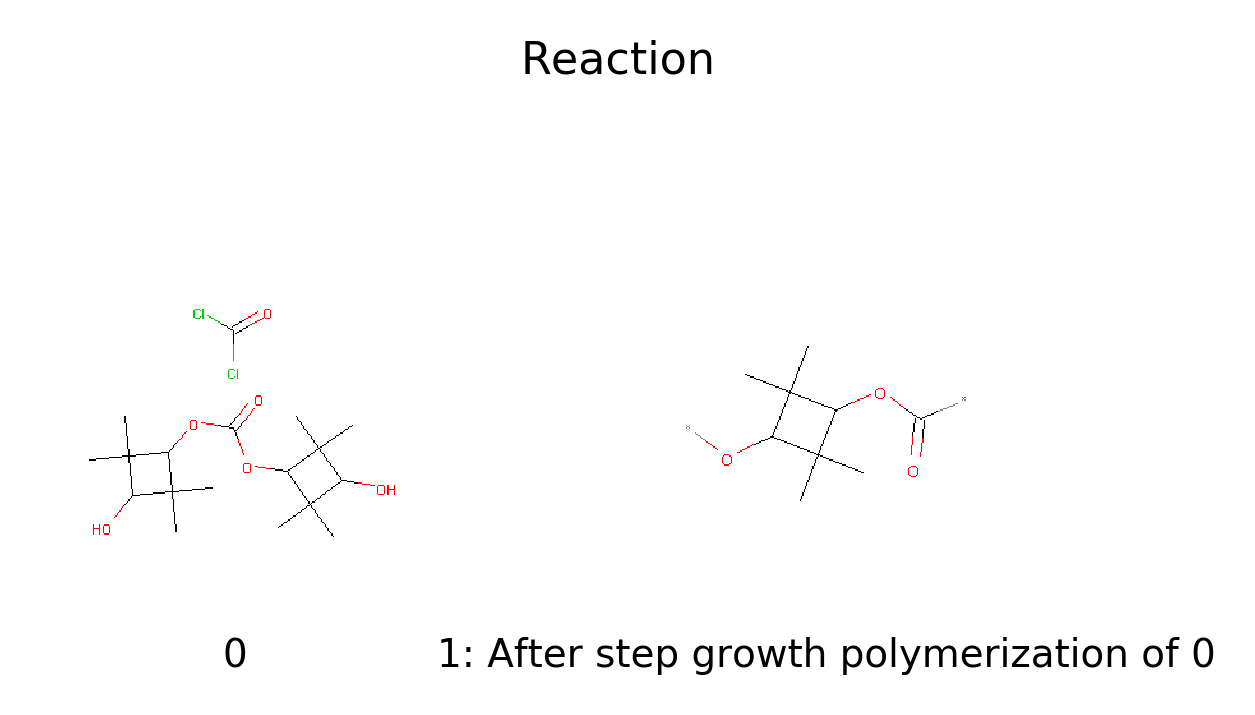

In [165]:
mpl.rcParams['figure.dpi']= 400
out[5].DrawSteps((3,2))

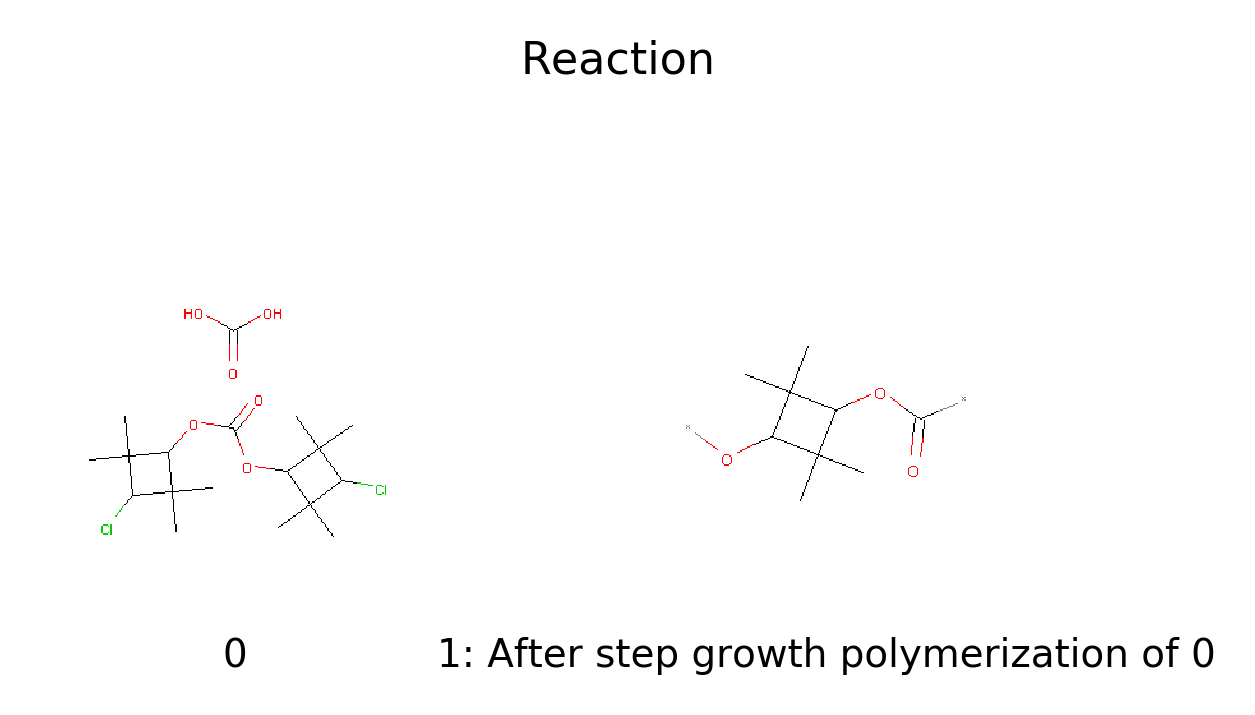

In [166]:
mpl.rcParams['figure.dpi']= 400
out[6].DrawSteps((3,2))

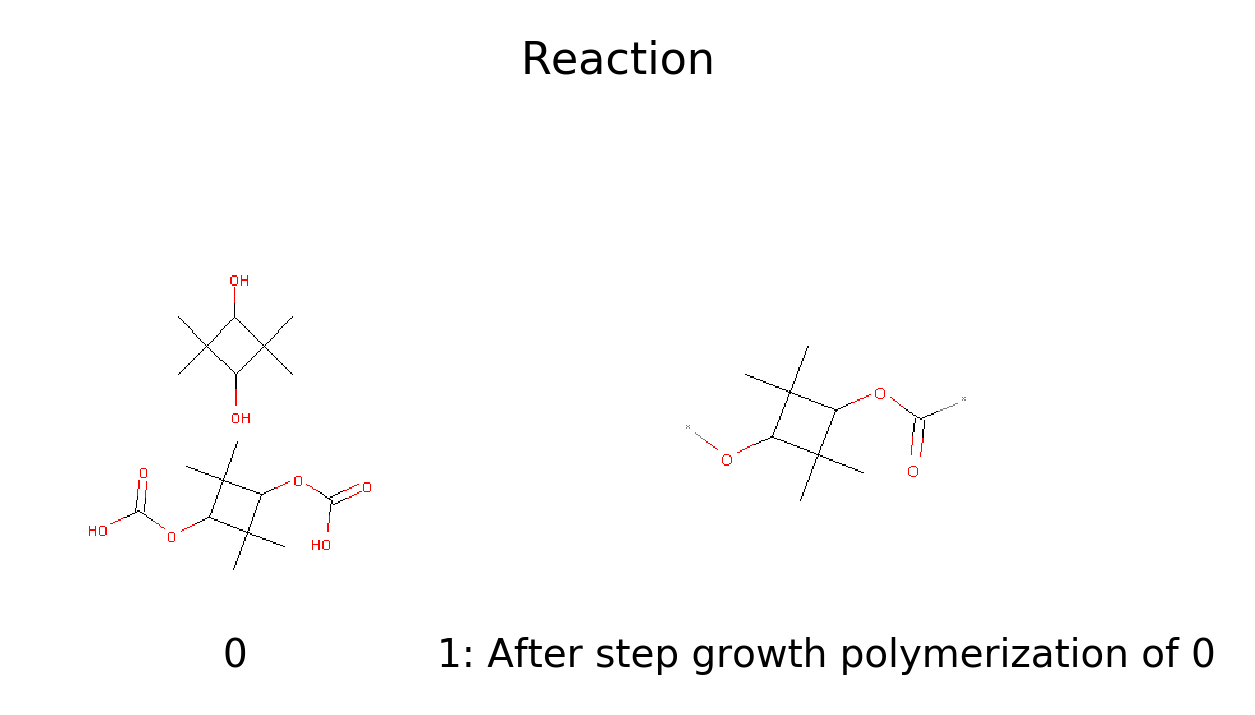

In [167]:
mpl.rcParams['figure.dpi']= 400
out[7].DrawSteps((3,2))

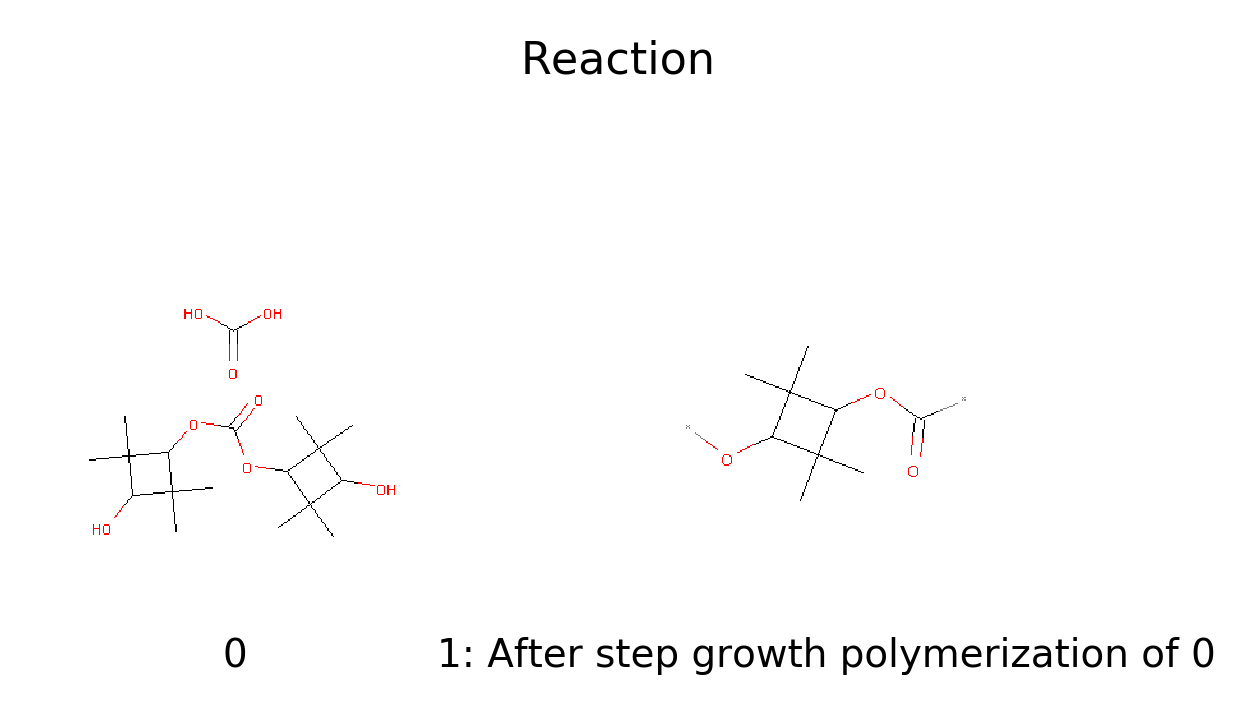

In [168]:
mpl.rcParams['figure.dpi']= 400
out[8].DrawSteps((3,2))

# Look into alternate paths for synthesis of RID: R1003252

In [172]:
importlib.reload(retro)
out = retro.retrosynthesize(['[*]OC(=O)OC1CC2CC([*])CC(C1)O2'],dimerize=True)
out

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
#######
[*]OC(=O)OC1CC2CC([*])CC(C1)O2
<function ring_close_retro at 0x7fb6267f1e18>
inner_RxnPaths len: 0
<function func_chain_retro at 0x7fb62381df28>
inner_RxnPaths len: 0
<function hydrogenate_chain at 0x7fb624f51bf8>
inner_RxnPaths len: 2
sm_RxnPaths len: 4


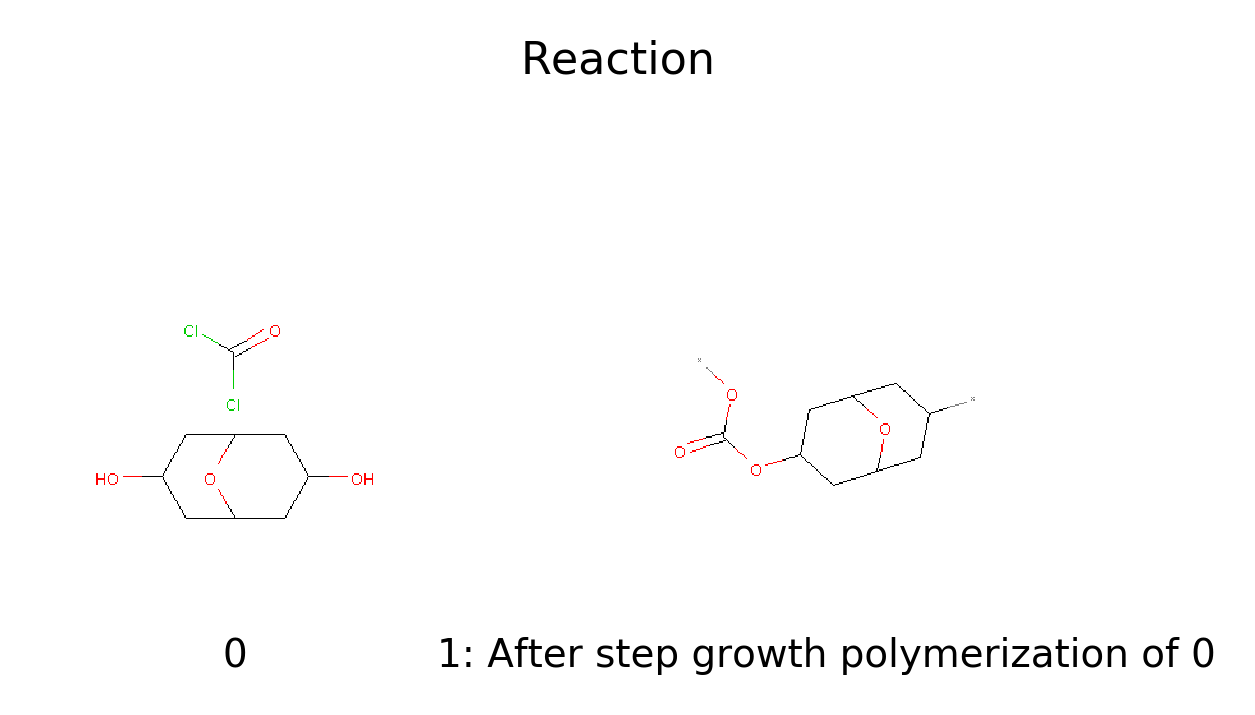

In [173]:
mpl.rcParams['figure.dpi']= 400
out[0].DrawSteps((3,2))

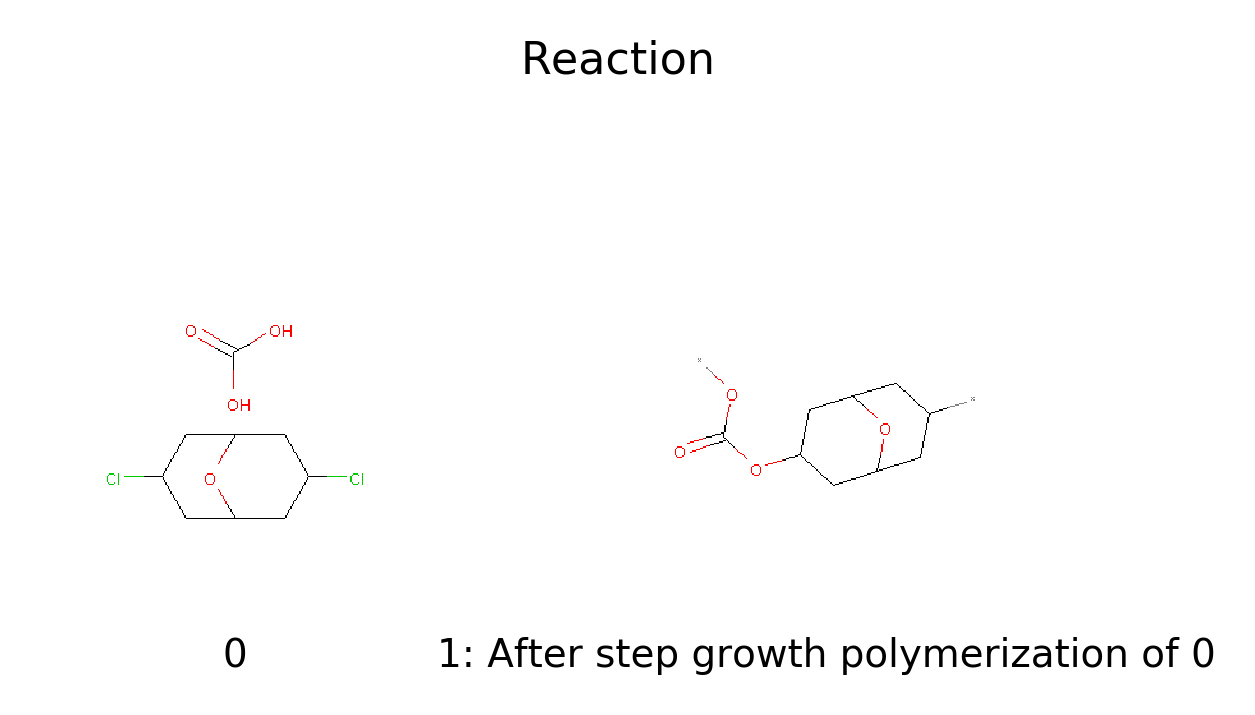

In [174]:
mpl.rcParams['figure.dpi']= 400
out[1].DrawSteps((3,2))

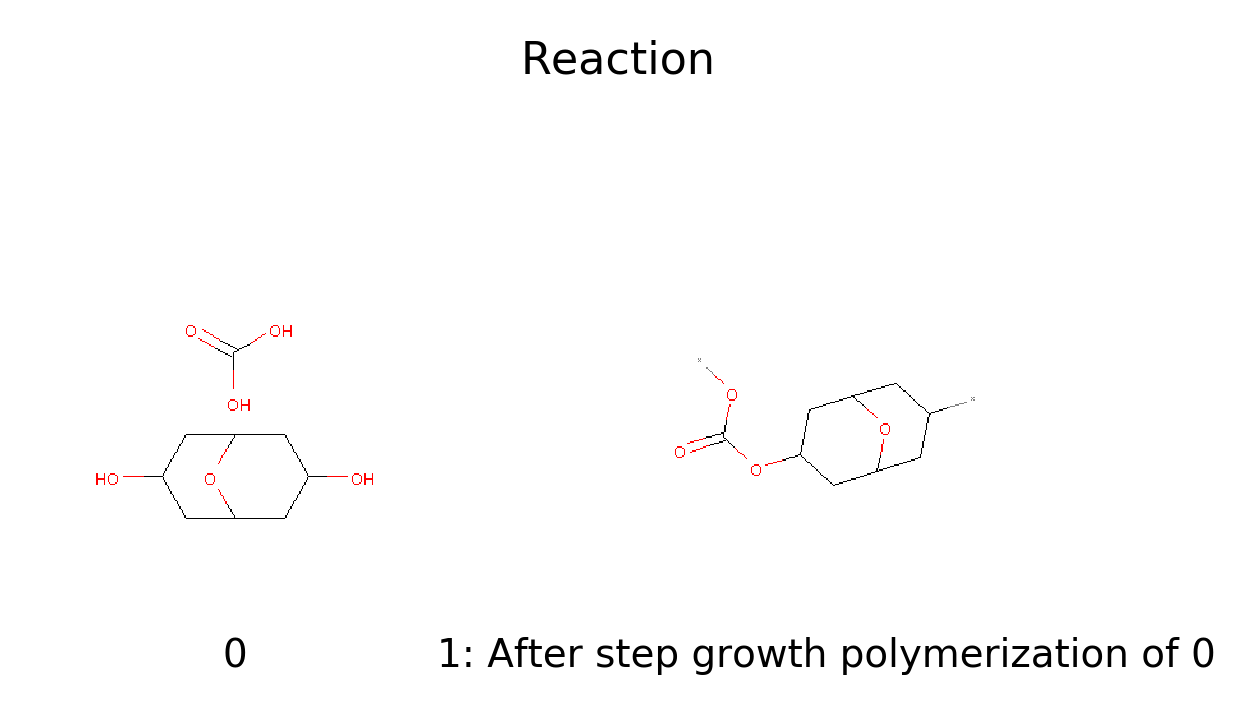

In [175]:
mpl.rcParams['figure.dpi']= 400
out[2].DrawSteps((3,2))

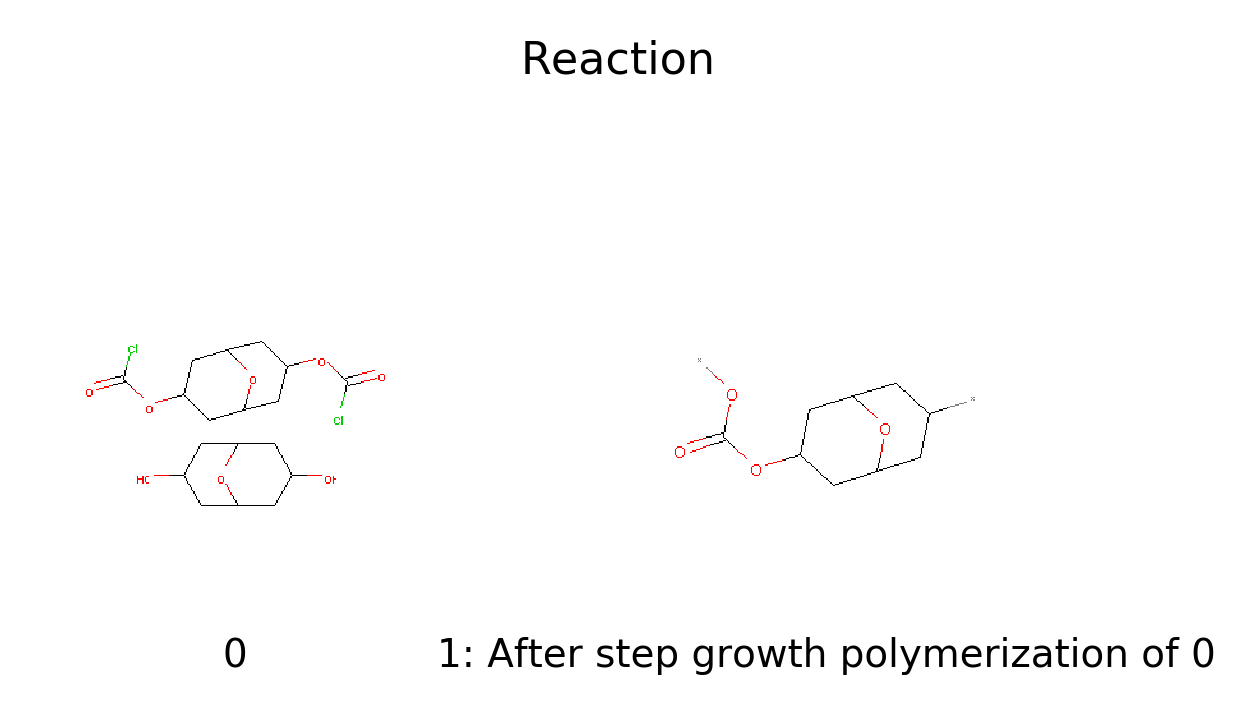

In [176]:
mpl.rcParams['figure.dpi']= 400
out[3].DrawSteps((3,2))

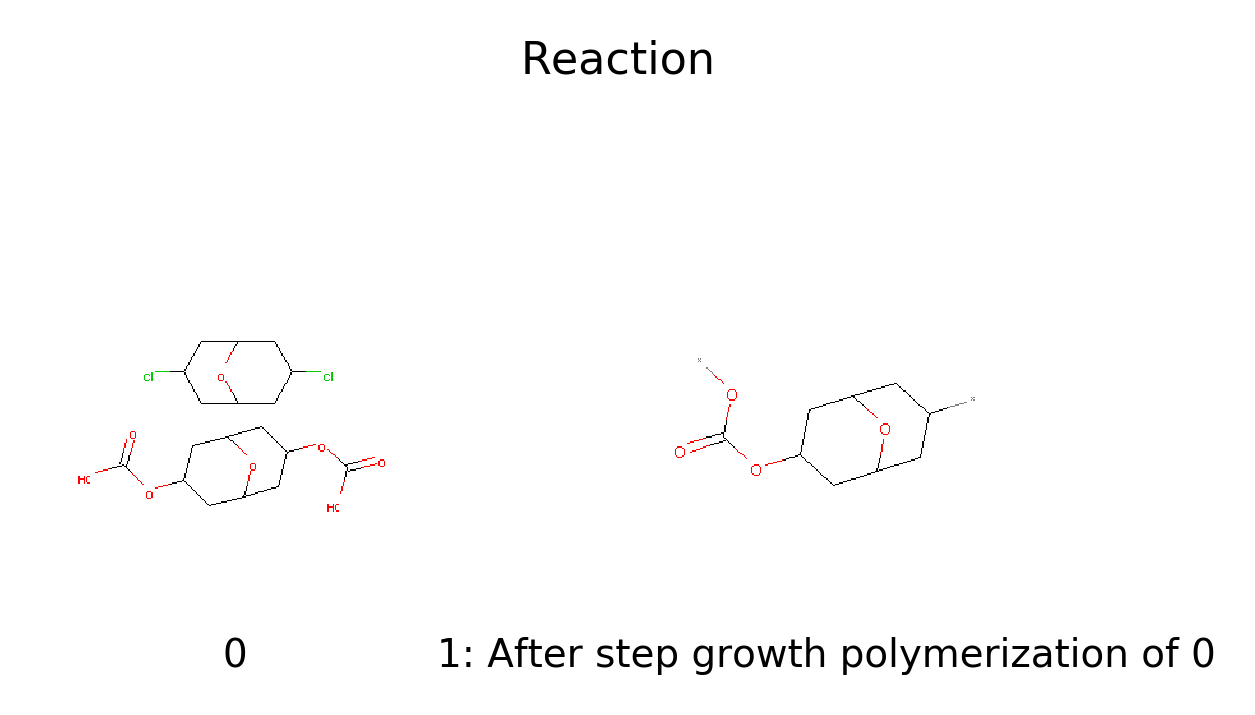

In [177]:
mpl.rcParams['figure.dpi']= 400
out[4].DrawSteps((3,2))

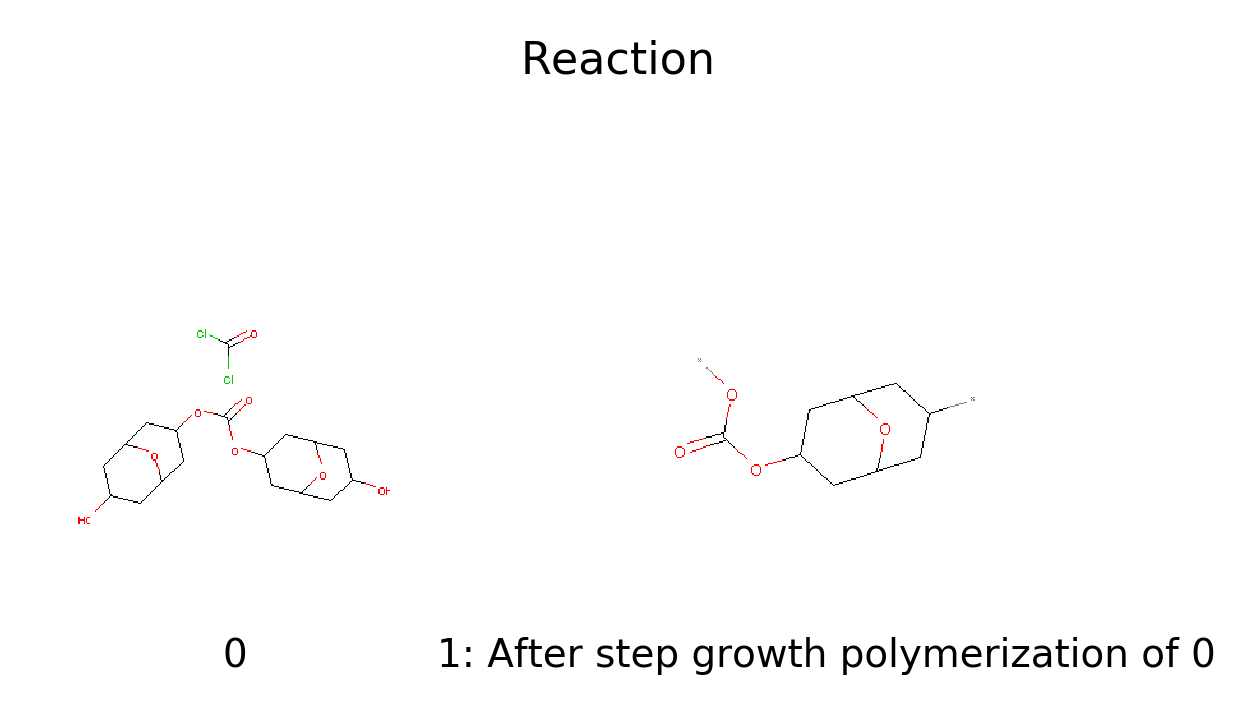

In [178]:
mpl.rcParams['figure.dpi']= 400
out[5].DrawSteps((3,2))

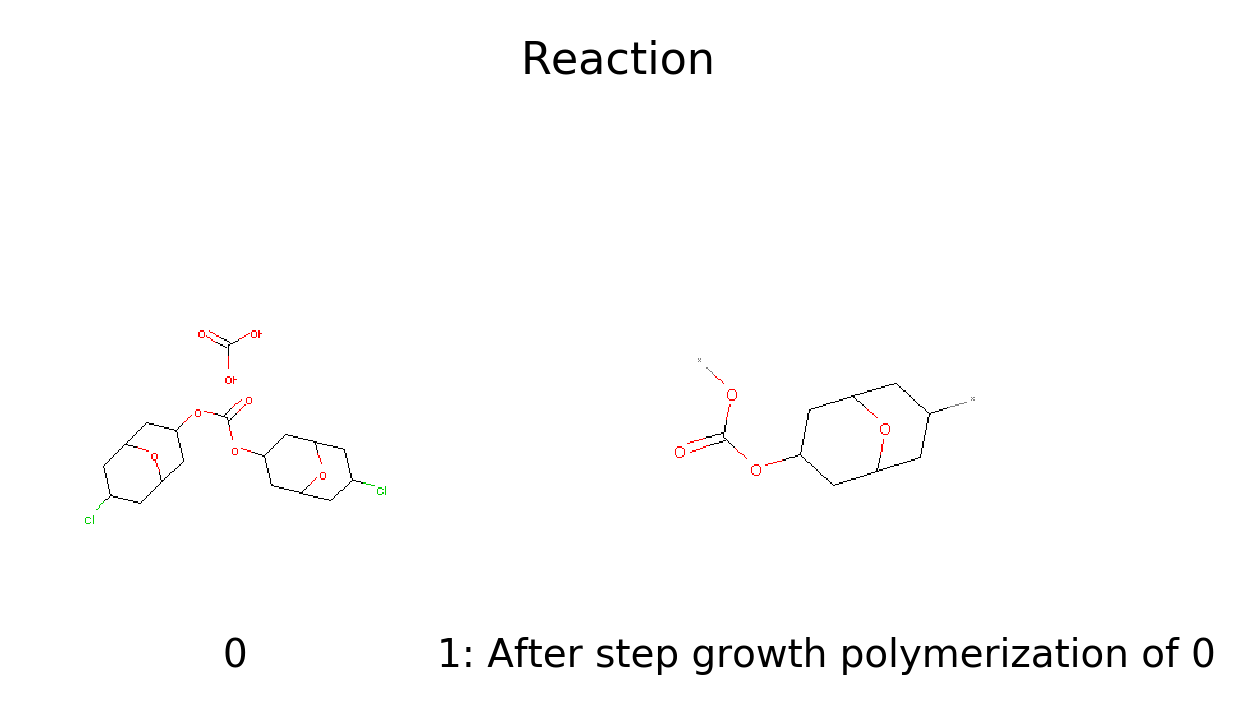

In [179]:
mpl.rcParams['figure.dpi']= 400
out[6].DrawSteps((3,2))

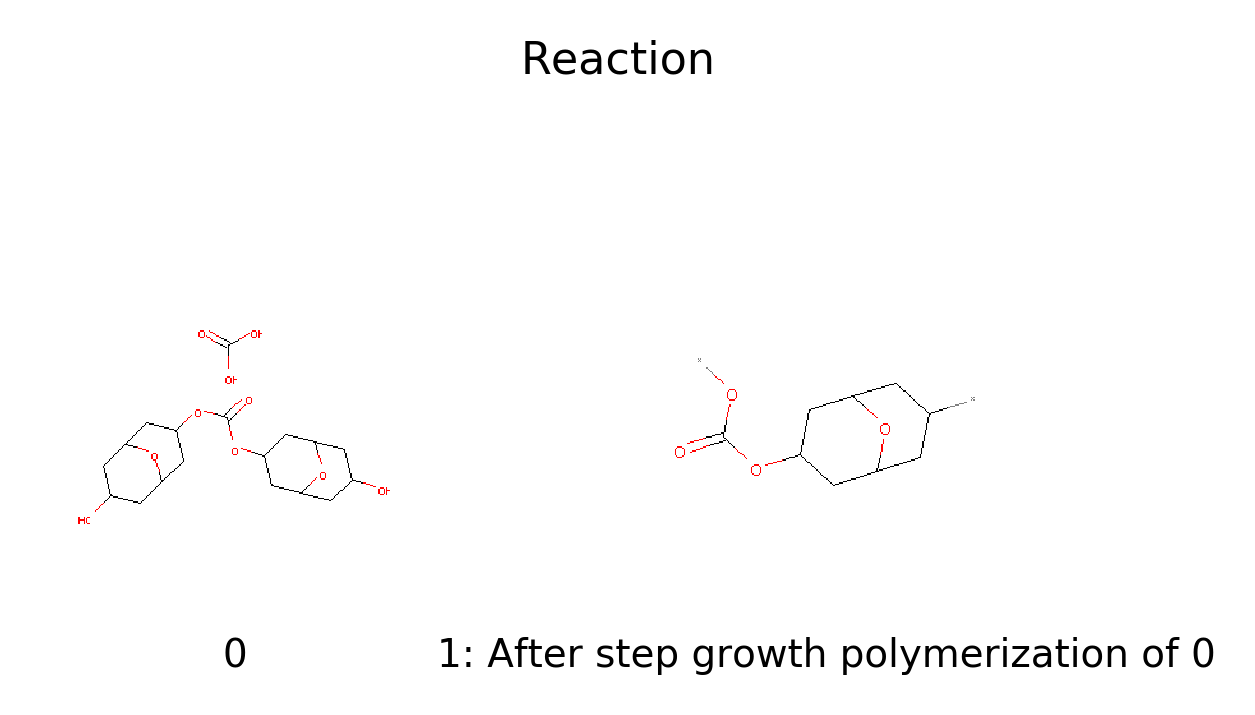

In [180]:
mpl.rcParams['figure.dpi']= 400
out[7].DrawSteps((3,2))

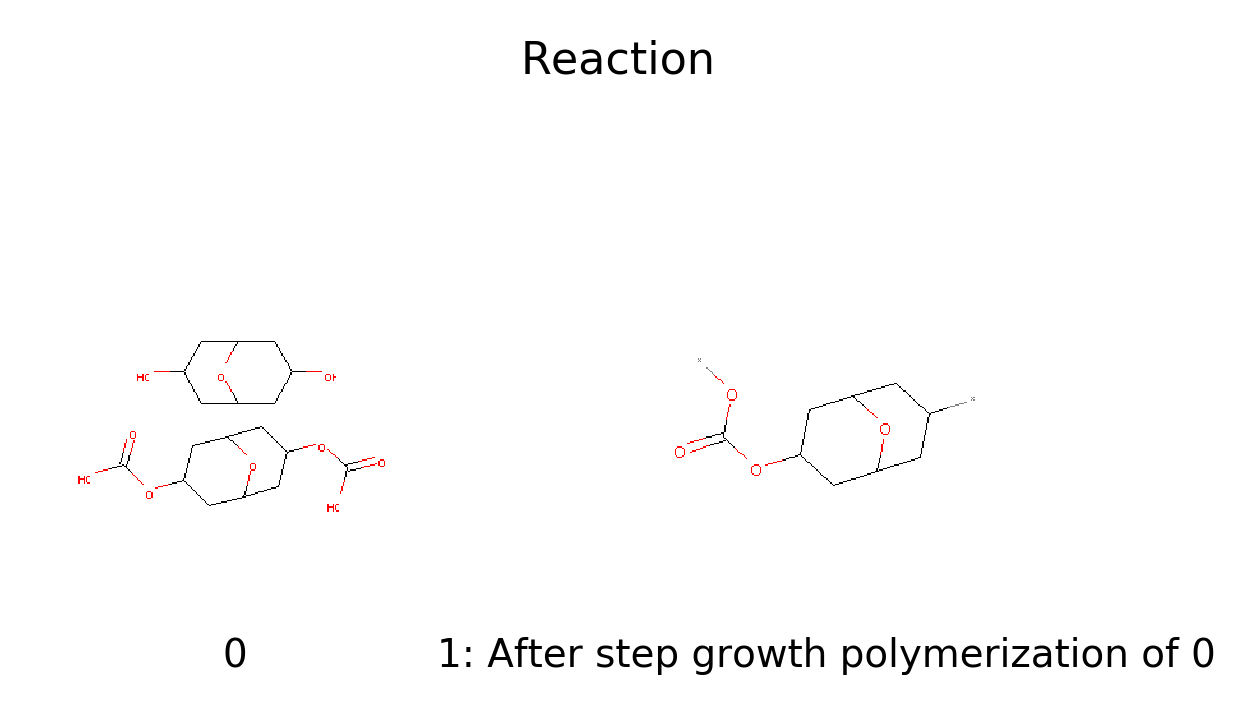

In [181]:
mpl.rcParams['figure.dpi']= 400
out[8].DrawSteps((3,2))

# Retrosynthesize the heated elimination of RCO2H

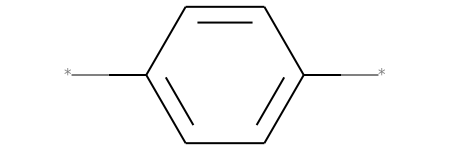

In [183]:
mol = Chem.MolFromSmiles('*c1ccc(*)cc1')
mol

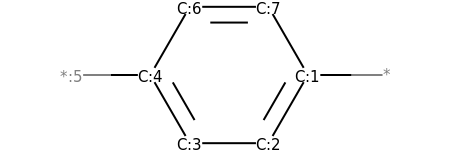

In [207]:
ru.mol_with_atom_index(mol)

In [184]:
lp = ru.LinearPol(mol)

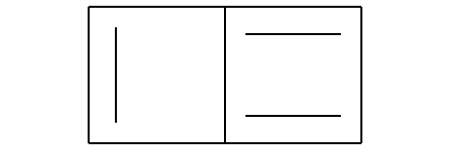

In [185]:
pm = lp.PeriodicMol()
pm.mol

In [186]:
replace_patt = Chem.MolFromSmarts('[c,C;R][c,C;R;!H0]')
pm.GetSubstructMatches(replace_patt)

((0, 1), (0, 5), (1, 2), (3, 2), (3, 4), (4, 5))

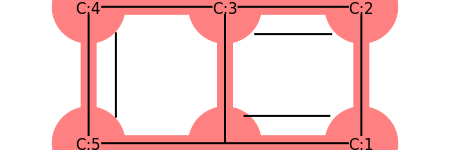

In [188]:
ru.mol_with_atom_index(pm.mol)

In [217]:
pm = lp.PeriodicMol()
match_combo = ((0,1),(3,2))
match_como_flat = ru.flatten_ll(match_combo)
n_replacements = len(match_combo)
if len(set(match_como_flat)) != len(match_como_flat): #no atoms should overlap
    print('None')
else:
    em = Chem.EditableMol(pm.mol)
    o_inds = [em.AddAtom(Chem.AtomFromSmiles('O')) for _ in range(n_replacements)]
    c_inds = [em.AddAtom(Chem.AtomFromSmiles('C')) for _ in range(n_replacements)]
    dbl_o_inds = [em.AddAtom(Chem.AtomFromSmiles('O')) for _ in range(n_replacements)]
    methyl_c_inds = [em.AddAtom(Chem.AtomFromSmiles('C')) for _ in range(n_replacements)]
    for i in range(n_replacements):
        em.AddBond(o_inds[i],match_combo[i][1],Chem.BondType.SINGLE)
        em.AddBond(c_inds[i],o_inds[i],Chem.BondType.SINGLE)
        em.AddBond(c_inds[i],dbl_o_inds[i],Chem.BondType.DOUBLE)
        em.AddBond(c_inds[i],methyl_c_inds[i],Chem.BondType.SINGLE)
    star1 = em.AddAtom(Chem.AtomFromSmiles('*'))
    star2 = em.AddAtom(Chem.AtomFromSmiles('*'))
    em.RemoveBond(pm.connector_inds[0],pm.connector_inds[1])
    em.AddBond(pm.connector_inds[0],star1,Chem.BondType.SINGLE)
    em.AddBond(pm.connector_inds[1],star2,Chem.BondType.SINGLE)

    new_mol = em.GetMol()
    for x in match_combo:
        new_mol.GetAtomWithIdx(x[1]).SetNumExplicitHs( pm.mol.GetAtomWithIdx(x[1]).GetNumImplicitHs() + 1 )
        new_mol.GetAtomWithIdx(x[0]).SetNumExplicitHs( pm.mol.GetAtomWithIdx(x[0]).GetNumImplicitHs() + 1 )
        print('#####')
        print(x[1])
        print(pm.mol.GetAtomWithIdx(x[1]).GetNumImplicitHs() + 1)
    Chem.SanitizeMol(new_mol)
    print()

#####
1
2
#####
2
2



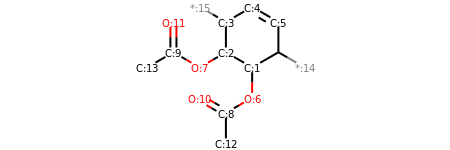

In [218]:
ru.mol_with_atom_index(new_mol)

# Test elim_RCO2H_retro

In [268]:
importlib.reload(retro)
out = retro.elim_RCO2H_retro(lp)
out

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


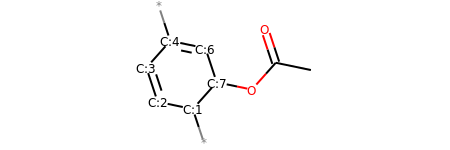

In [270]:
out[1]

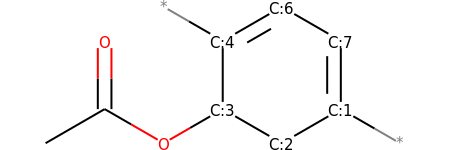

In [271]:
out[2]

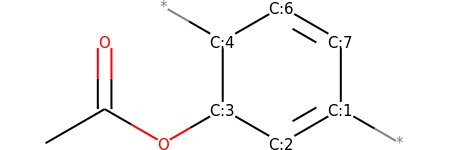

In [272]:
out[3]

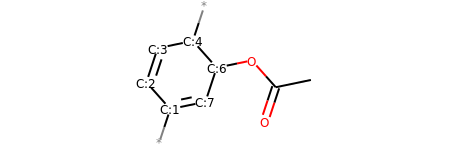

In [273]:
out[4]

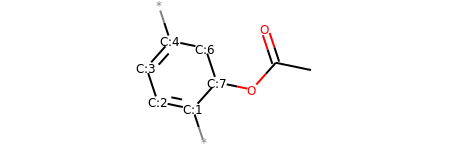

In [274]:
out[5]

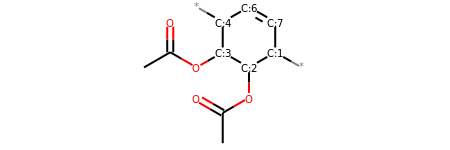

In [275]:
out[6]

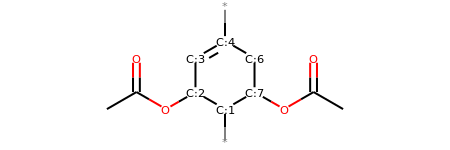

In [276]:
out[7]

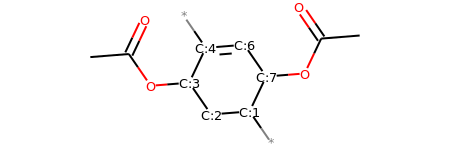

In [277]:
out[8]

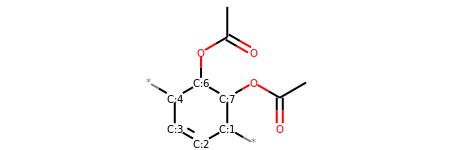

In [278]:
out[9]

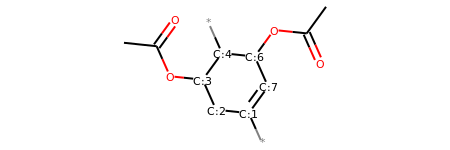

In [279]:
out[10]

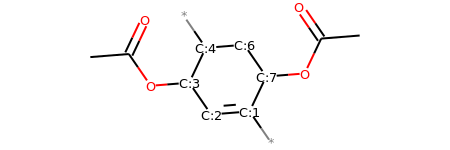

In [280]:
out[11]

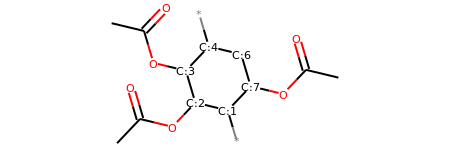

In [281]:
out[12]

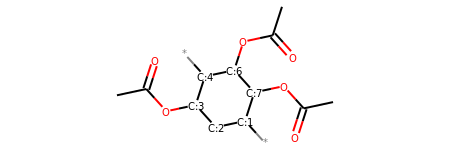

In [282]:
out[13]

In [323]:
importlib.reload(retro)
out = retro.retrosynthesize(['*c1ccc(*)cc1'])
out

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
#######
*c1ccc(*)cc1
<function ring_close_retro at 0x7fb62452a8c8>
inner_RxnPaths len: 0
<function func_chain_retro at 0x7fb6243de268>
inner_RxnPaths len: 0
<function hydrogenate_chain at 0x7fb62452abf8>
inner_RxnPaths len: 0
<function elim_RCO2H_retro at 0x7fb62452a378>
inner_RxnPaths len: 6
sm_RxnPaths len: 7


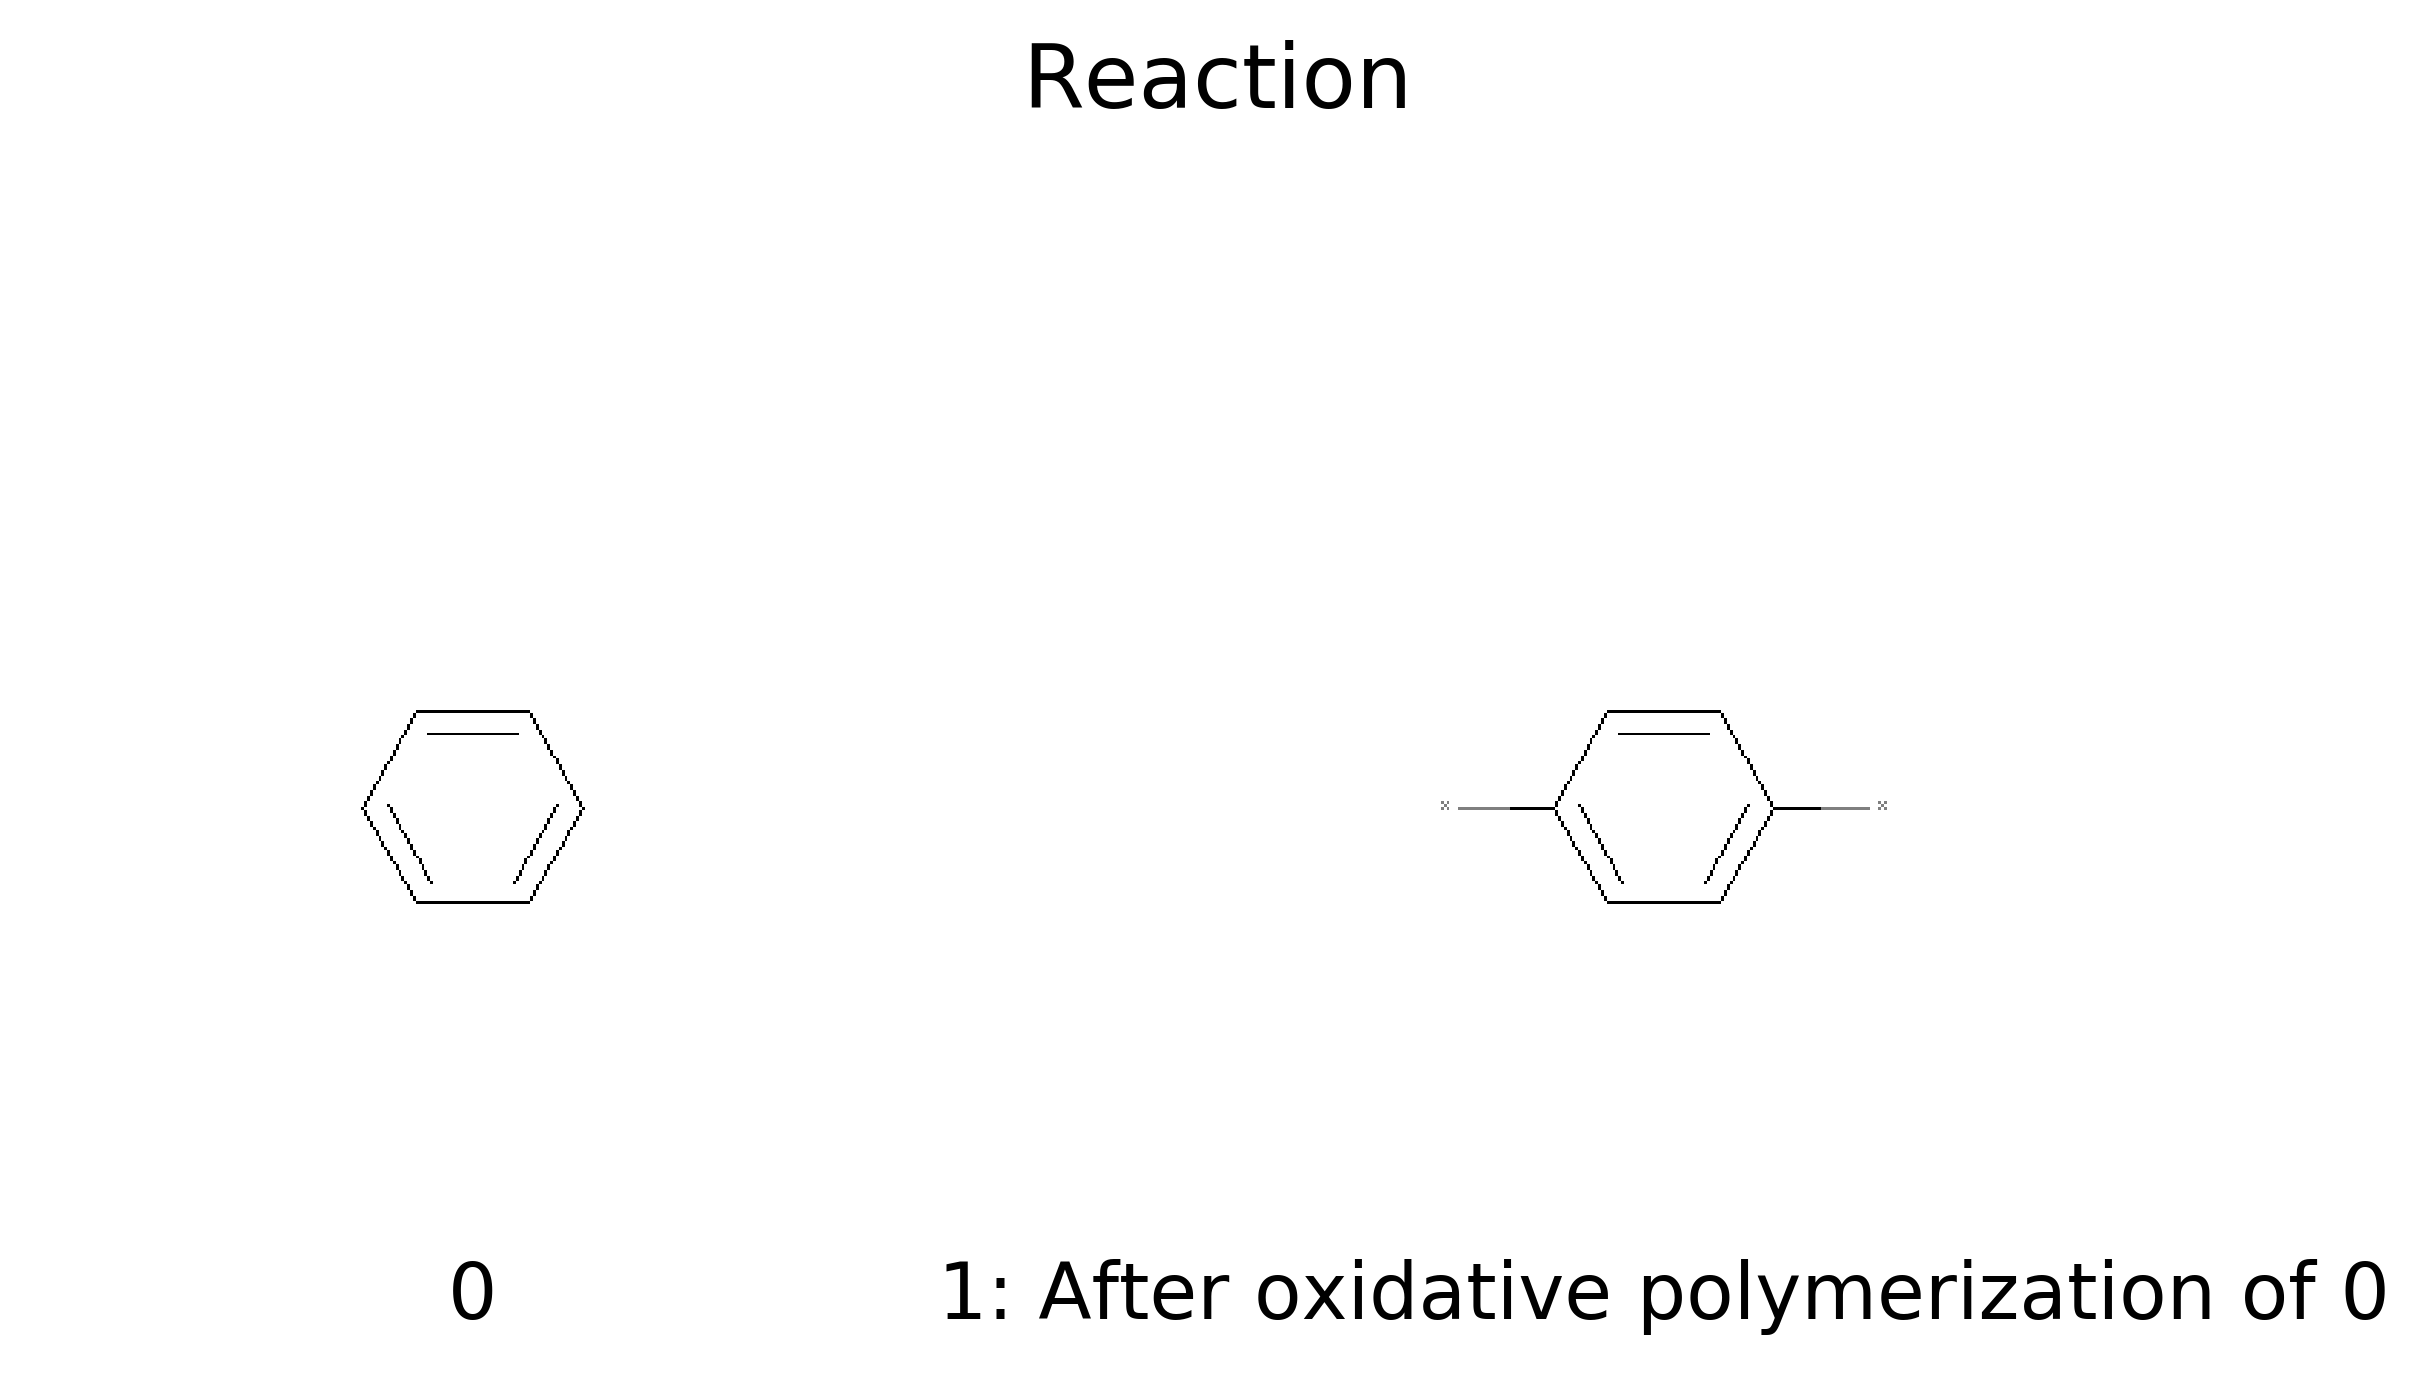

In [324]:
out[0].DrawSteps()

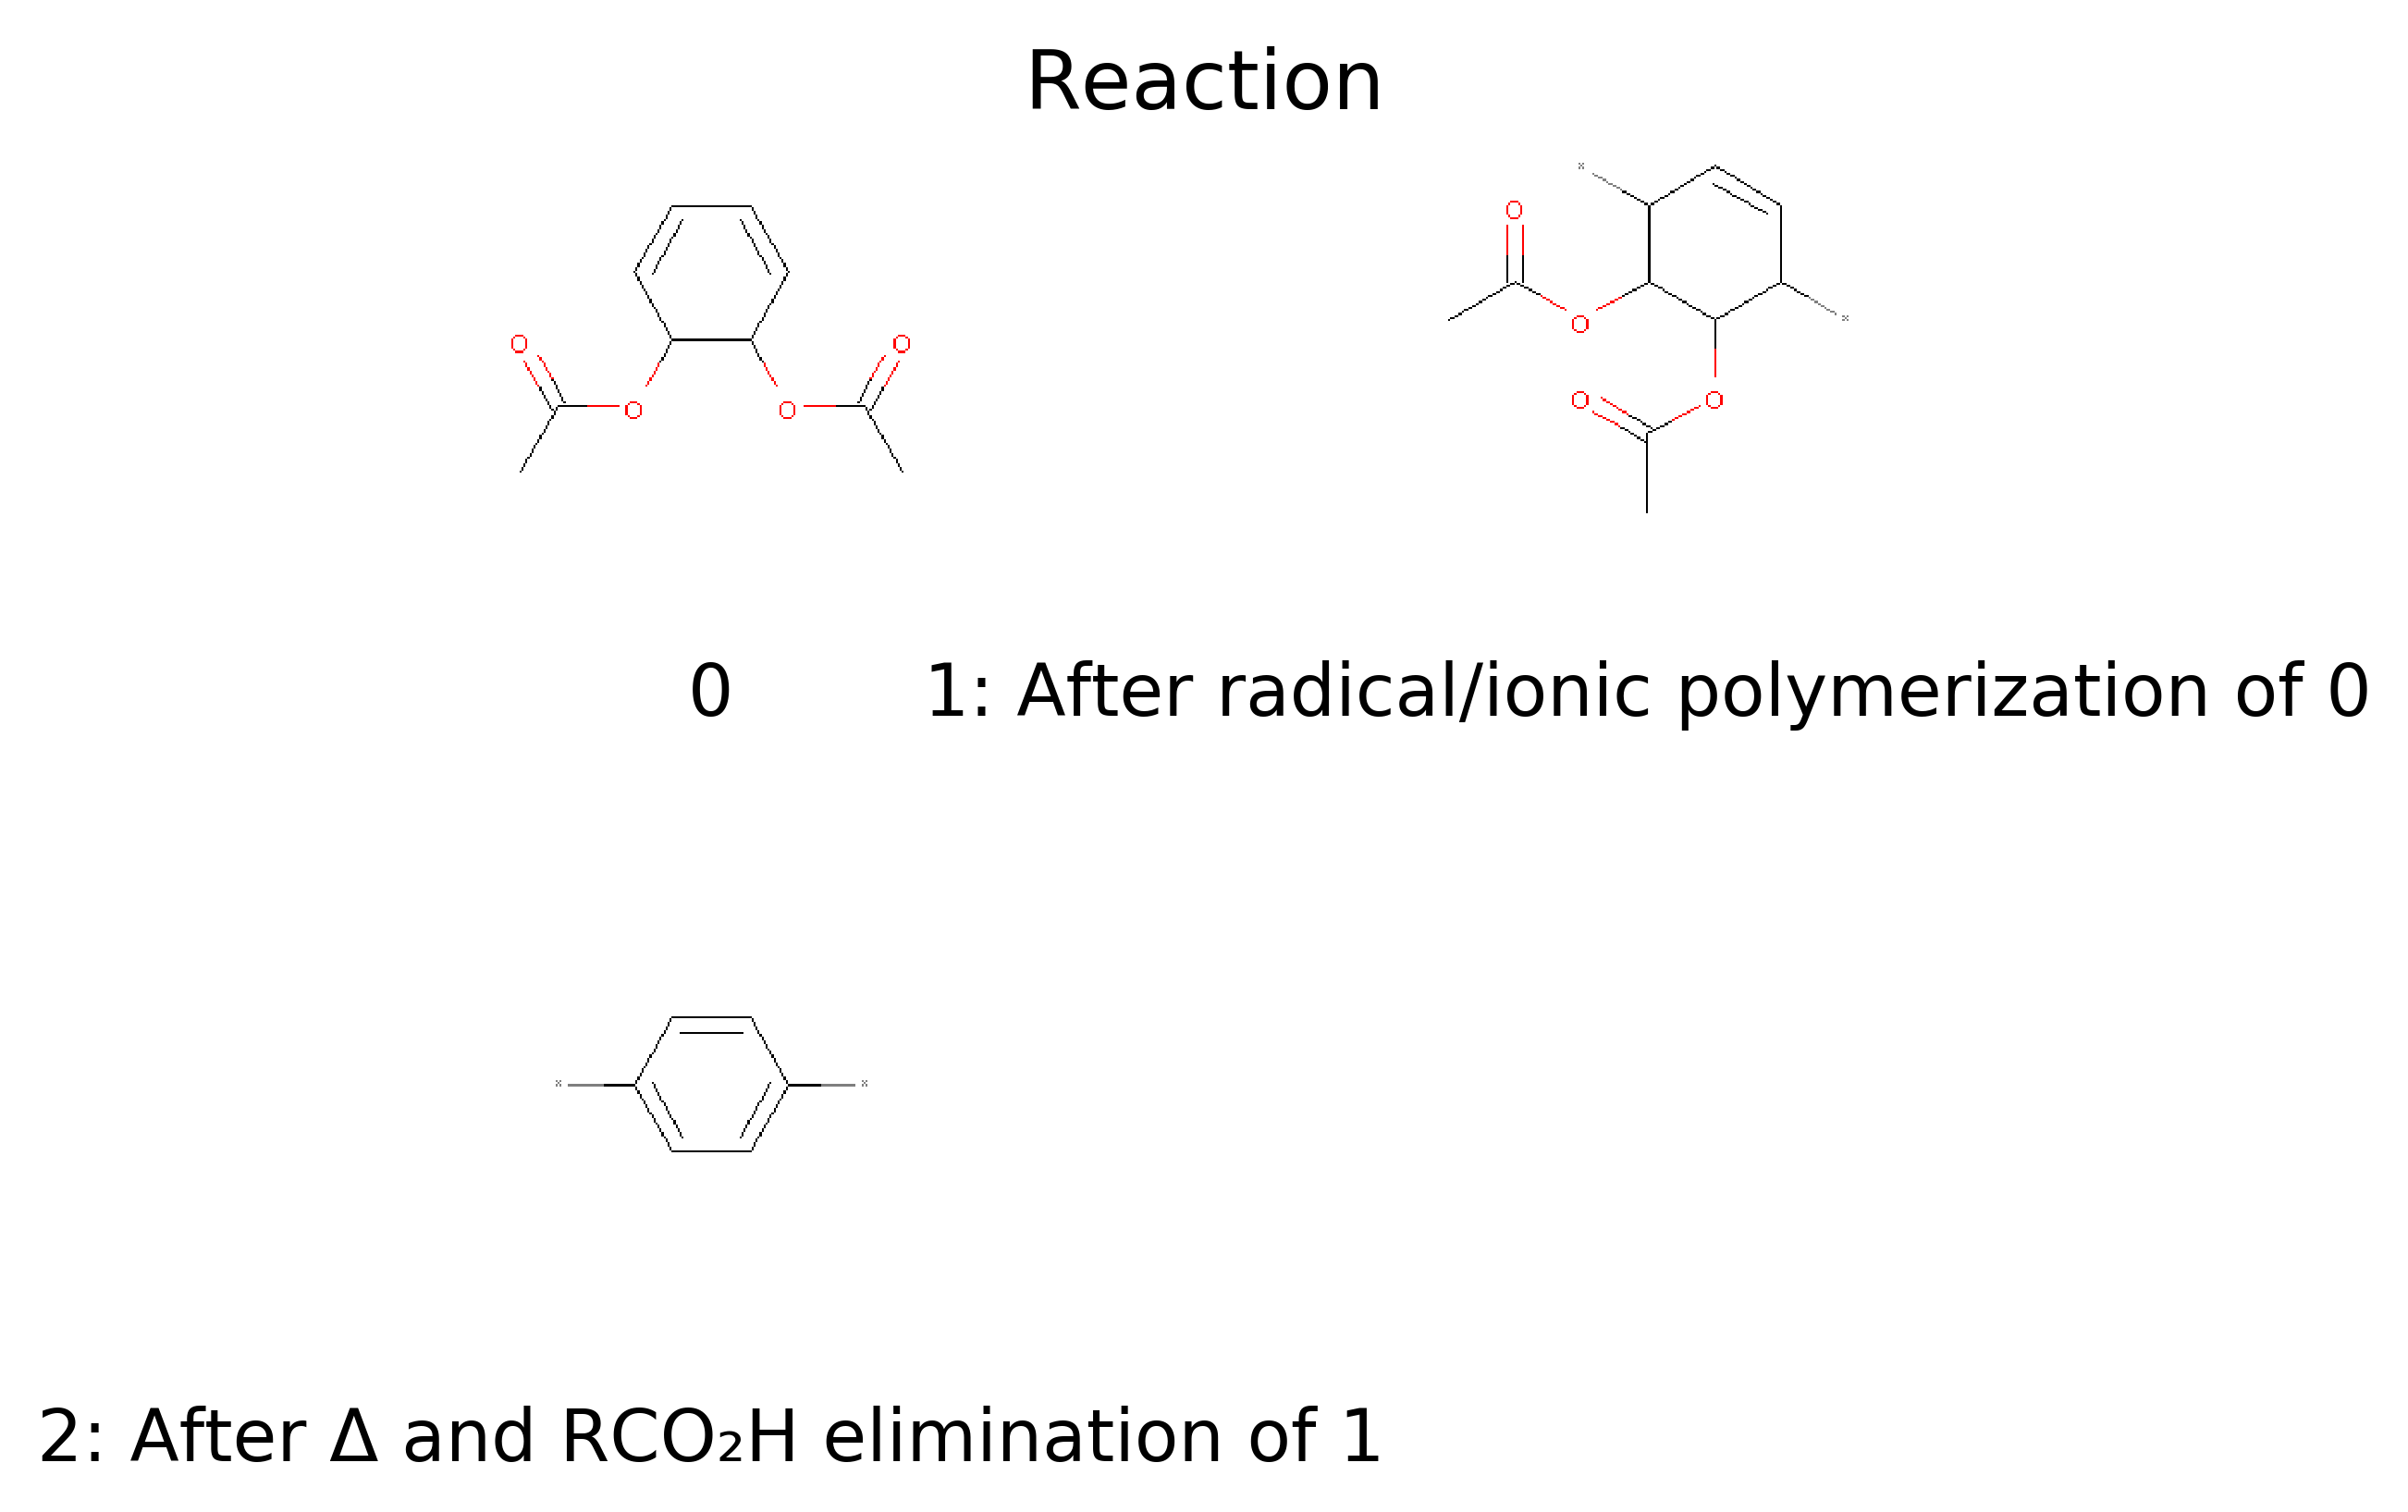

In [325]:
out[1].DrawSteps()

In [283]:
retro.frp_depolymerize(out[9])

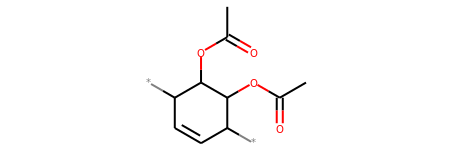

In [285]:
ru.mol_without_atom_index(out[9])

# Work on FRP for multiple-double bonds

In [305]:
rxn = Chem.AllChem.ReactionFromSmarts('[*:1][CR:3]([#0:2])[CHR:4]=[CHR:5][CR:6]([#0:7])[*:9]>>[*:1][CR:3]=[CR:4][CR:5]=[CR:6][*:9]')

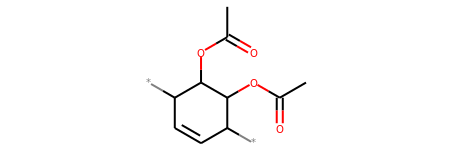

In [306]:
ru.mol_without_atom_index(out[9])

In [307]:
prods = rxn.RunReactants((ru.mol_without_atom_index(out[9]),))

In [308]:
prods

((<rdkit.Chem.rdchem.Mol at 0x7fb6242d9870>,),
 (<rdkit.Chem.rdchem.Mol at 0x7fb6242d9500>,))

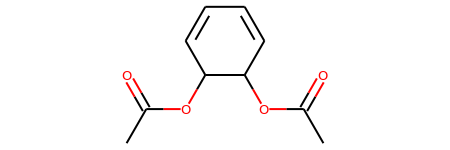

In [309]:
prods[1][0]

In [312]:
Chem.SanitizeMol(prods[0][0])

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

# Test FRP for multiple-double bonds

Restored variables from /data/rgur/retrosynthesis/scscore/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz


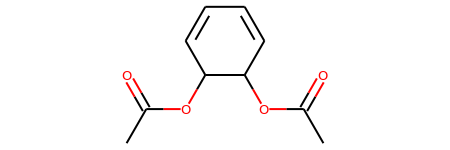

In [316]:
importlib.reload(retro)
retro.frp_depolymerize(ru.mol_without_atom_index(out[9]))[0]